## 영화 관객수 예측
### 목표: 영화흥행에 가장 중요한 요소 파악 및 개봉영화 관객 수 예측


#### requirements

In [ ]:
import seaborn as sns
import pandas as pd
import re
import matplotlib as mpl
from matplotlib import rc
import missingno as msno
import warnings
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings('ignore')

# matplotlib 한글 사용을 위한 코드
rc('font', family='AppleGothic')
mpl.rc('font', family='Hancom Gothic')
mpl.rc('axes', unicode_minus=False)

from IPython.display import Image


### 0. 컬럼 설명
- 독립변수
    - KOBIS(개봉일람, 2015-2019, 6개월 단위 TOP100위)
    - title : 영화 제목
    - director : 감독 이름
    - distributor(obj) : 배급사
    - distributor_group(obj) : 배급사 카테고리화(매출액 기준)
        - A : 씨제이이엔엠, 메가박스중앙, CGV 아트하우스, 롯데, 쇼박스, 넥스트엔터테인먼트(NEW) 외 관련 합작사
        - B : 월트디즈니, 이십세기폭스, 유니버설픽쳐스, 워너브러더스 코리아, 씨네그루, 이수C&E, 티캐스트, 소니픽쳐스, 스톰픽쳐코리아, 키위컴퍼니, 에이원엔터테이먼트, 셀트리온엔터테인먼트, 케이티하이텔_1건, 관련 합작사
        - C : 아이코닉스, CBS, 홈초이스, 애니플러스, 마운틴픽쳐스, 그 외 소규모 영화사
    - releas_season(obj) : 영화가 개봉한 날의 계절
    - nation(obj, 5개) :
        - 미국, 한국, 영국, 일본, 프랑스, 기타
        - 24개 국적에서 개수 10개 이하 국가를 기타로 통합
    - screen(int) : 영화가 걸렸던 스크린 개수
    - genre(obj, 14개) :
        - 액션, 드라마, 사극, 코미디, 애니메이션, 스릴러, 멜로/로멘스, 범죄, 어드벤처, 다큐멘터리, 미스터리, SF, 공포, 판타지
        - 기존 19개 장르에서 개수 10개 미만 소수 장르 통합
    - rate(obj) : 영화등급
        - 전체관람가
        - 12세 이상
        - 15세 이상
        - 청소년 관람불가
    - director_power(float) : 해당 영화의 개봉년 기준 3년 내 연출한 영화들의 관람객(2012-2019) 총 합(동명이인 체크)
    - actor_power(int) : 해당 영화의 개봉년 기준 3년 내 주연 출연한 영화들의 관람객(2012-2019) 총 합(동명이인 체크)
    ------------------------------------------------------------------------------------------------------------------------------------
    - 크롤링(네이버 뉴스, 영화 사이트)으로 얻은 자료
    - audience_rating(float) : 네이버 영화 사이트 관람객 평점(개봉 1주일 내)
    - rating_audiences(int) : 네이버 영화 사이트에서 평점을 매긴 관람객 수(개봉 1주일 내)
    - actor_power(int) : 개봉년 기준 3년 내 주연 출연한 영화들의 관람객 총 합
    - news(int) : 개봉 1주일 전후 해당 영화 관련 기사
    - 리서치로 얻은 자료
    - sequel(boolean) : 시리즈물 여부(boolean(binomiel))
    - original(boolean) : 원작(책, 소설, 영상물) 존재, 실화 여부
- 종속변수
    - aud_nationwide : 전국관객수(한국에서의 영화흥행기준)

### 1. Data 불러오기

In [76]:
X_train = pd.read_csv('X_train_09.csv').drop(columns='Unnamed: 0')
y_train = pd.read_csv('y_train_09.csv').drop(columns='Unnamed: 0')
X_test = pd.read_csv('X_test_09.csv').drop(columns='Unnamed: 0')
y_test = pd.read_csv('y_test_09.csv').drop(columns='Unnamed: 0')

In [77]:
df_train_09 = pd.concat([X_train, y_train], axis=1)
df_test_09 = pd.concat([X_test, y_test], axis=1)

df_final_09 = pd.concat([df_train_09, df_test_09], axis=0)

In [63]:
df_final_02 = pd.read_csv("../linear_regression_project/yeejun/final_df_02.csv").drop(columns='Unnamed: 0')

In [82]:
df_final_03 = pd.read_csv("final_df_03_ols.csv")
df_final_03 = df_final_03.drop("Unnamed: 0", axis=1)

### 2. EDA

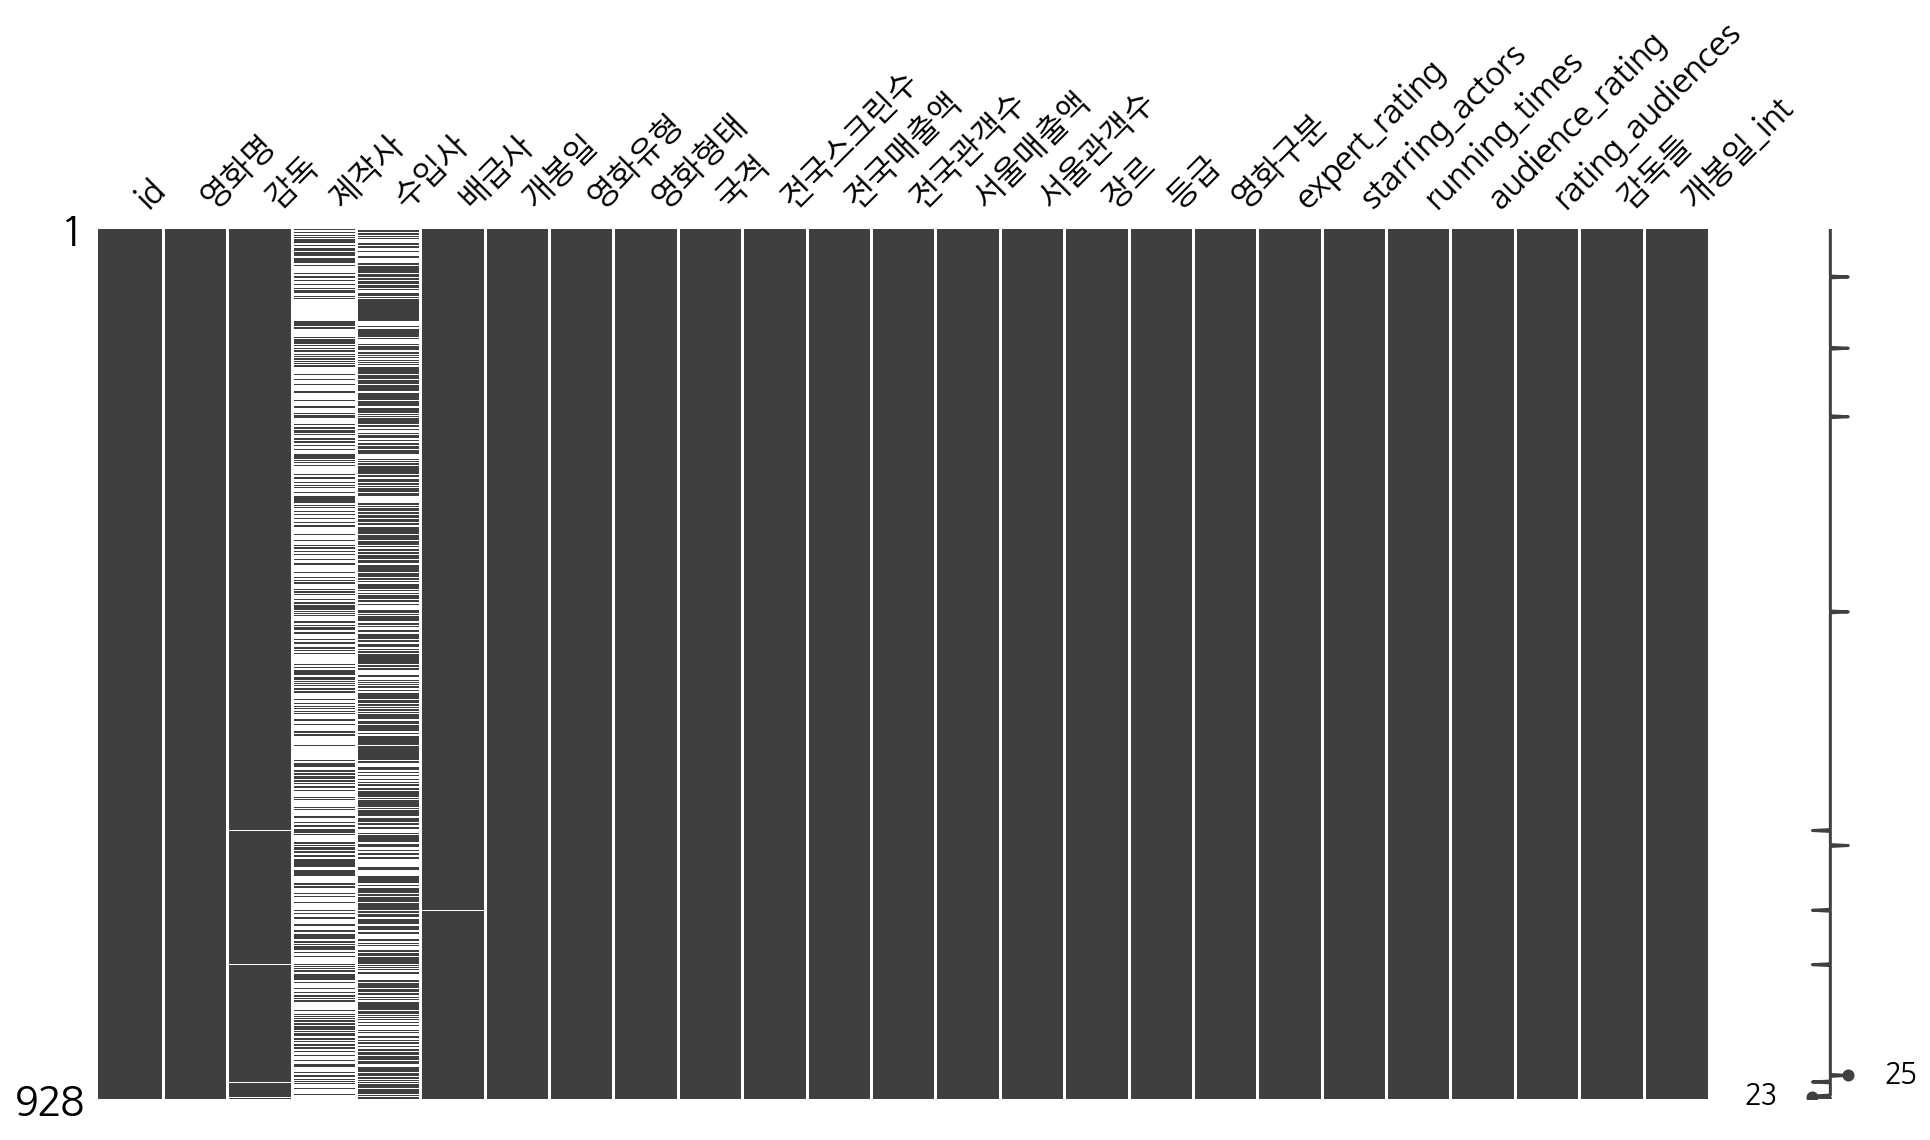

In [64]:
msno.matrix(df_final_02, figsize=(16, 8))
plt.show()

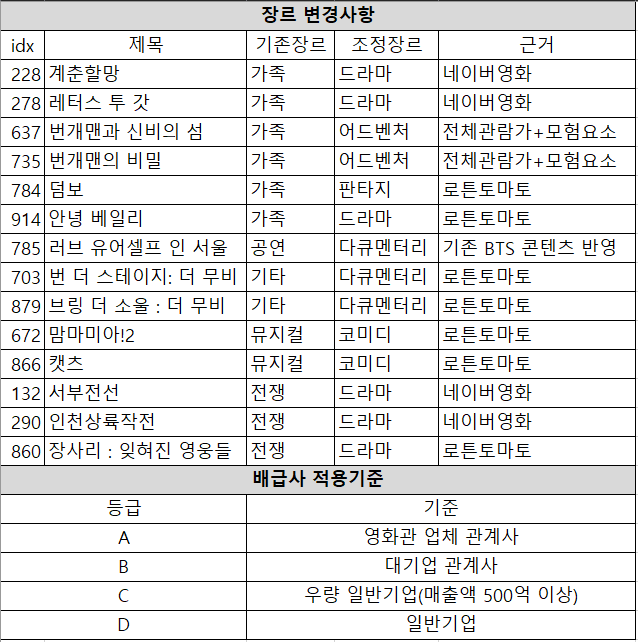

In [73]:
Image("./bitna\distributor_criteria.PNG")

#### 카테고리 컬럼 정리

In [83]:
df_distributor = df_final_03.groupby('배급사').size().reset_index()
df_distributor = df_distributor.rename(columns={0:'count'})
df_distributor_sort = df_distributor.sort_values('count', ascending=False)
df_distributor_sort = df_distributor_sort.reset_index().drop('index', axis=1)
df_distributor_sort

,배급사,count
0,씨제이이앤엠(주),85
1,유니버설픽쳐스인터내셔널 코리아(유),77
2,(주)넥스트엔터테인먼트월드(NEW),67
3,워너브러더스 코리아(주),63
4,롯데쇼핑㈜롯데엔터테인먼트,52
...,...,...
135,(주)시네마달,1
136,"(주)스톰픽쳐스코리아,주식회사 우리네트웍스",1
137,"(주)스톰픽쳐스코리아,(주)페퍼민트앤컴퍼니",1
138,"(주)스마일이엔티,(주)영화사오원",1


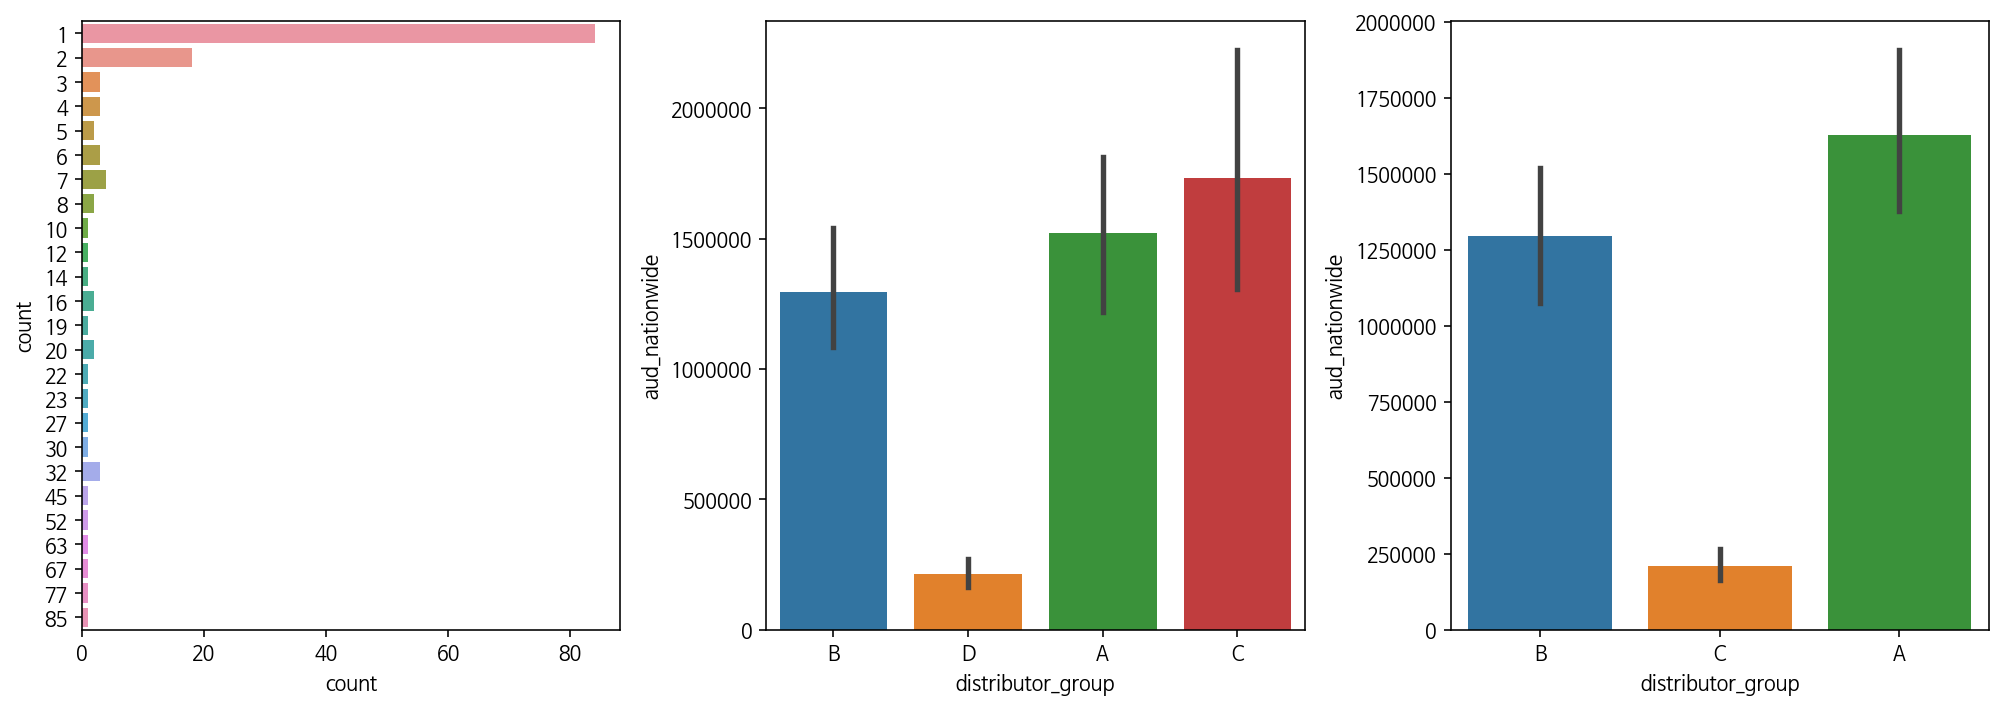

In [87]:
#### 배급사 그룹화 정리
plt.figure(figsize=(14, 5))

plt.subplot(131)
sns.countplot(y='count', data=df_distributor_sort)

plt.subplot(132)
sns.barplot(x=df_final_09["distributor_group"], y=df_final_09["aud_nationwide"])

plt.subplot(133)
sns.barplot(x=df["distributor_group"], y=df["aud_nationwide"])

plt.tight_layout()


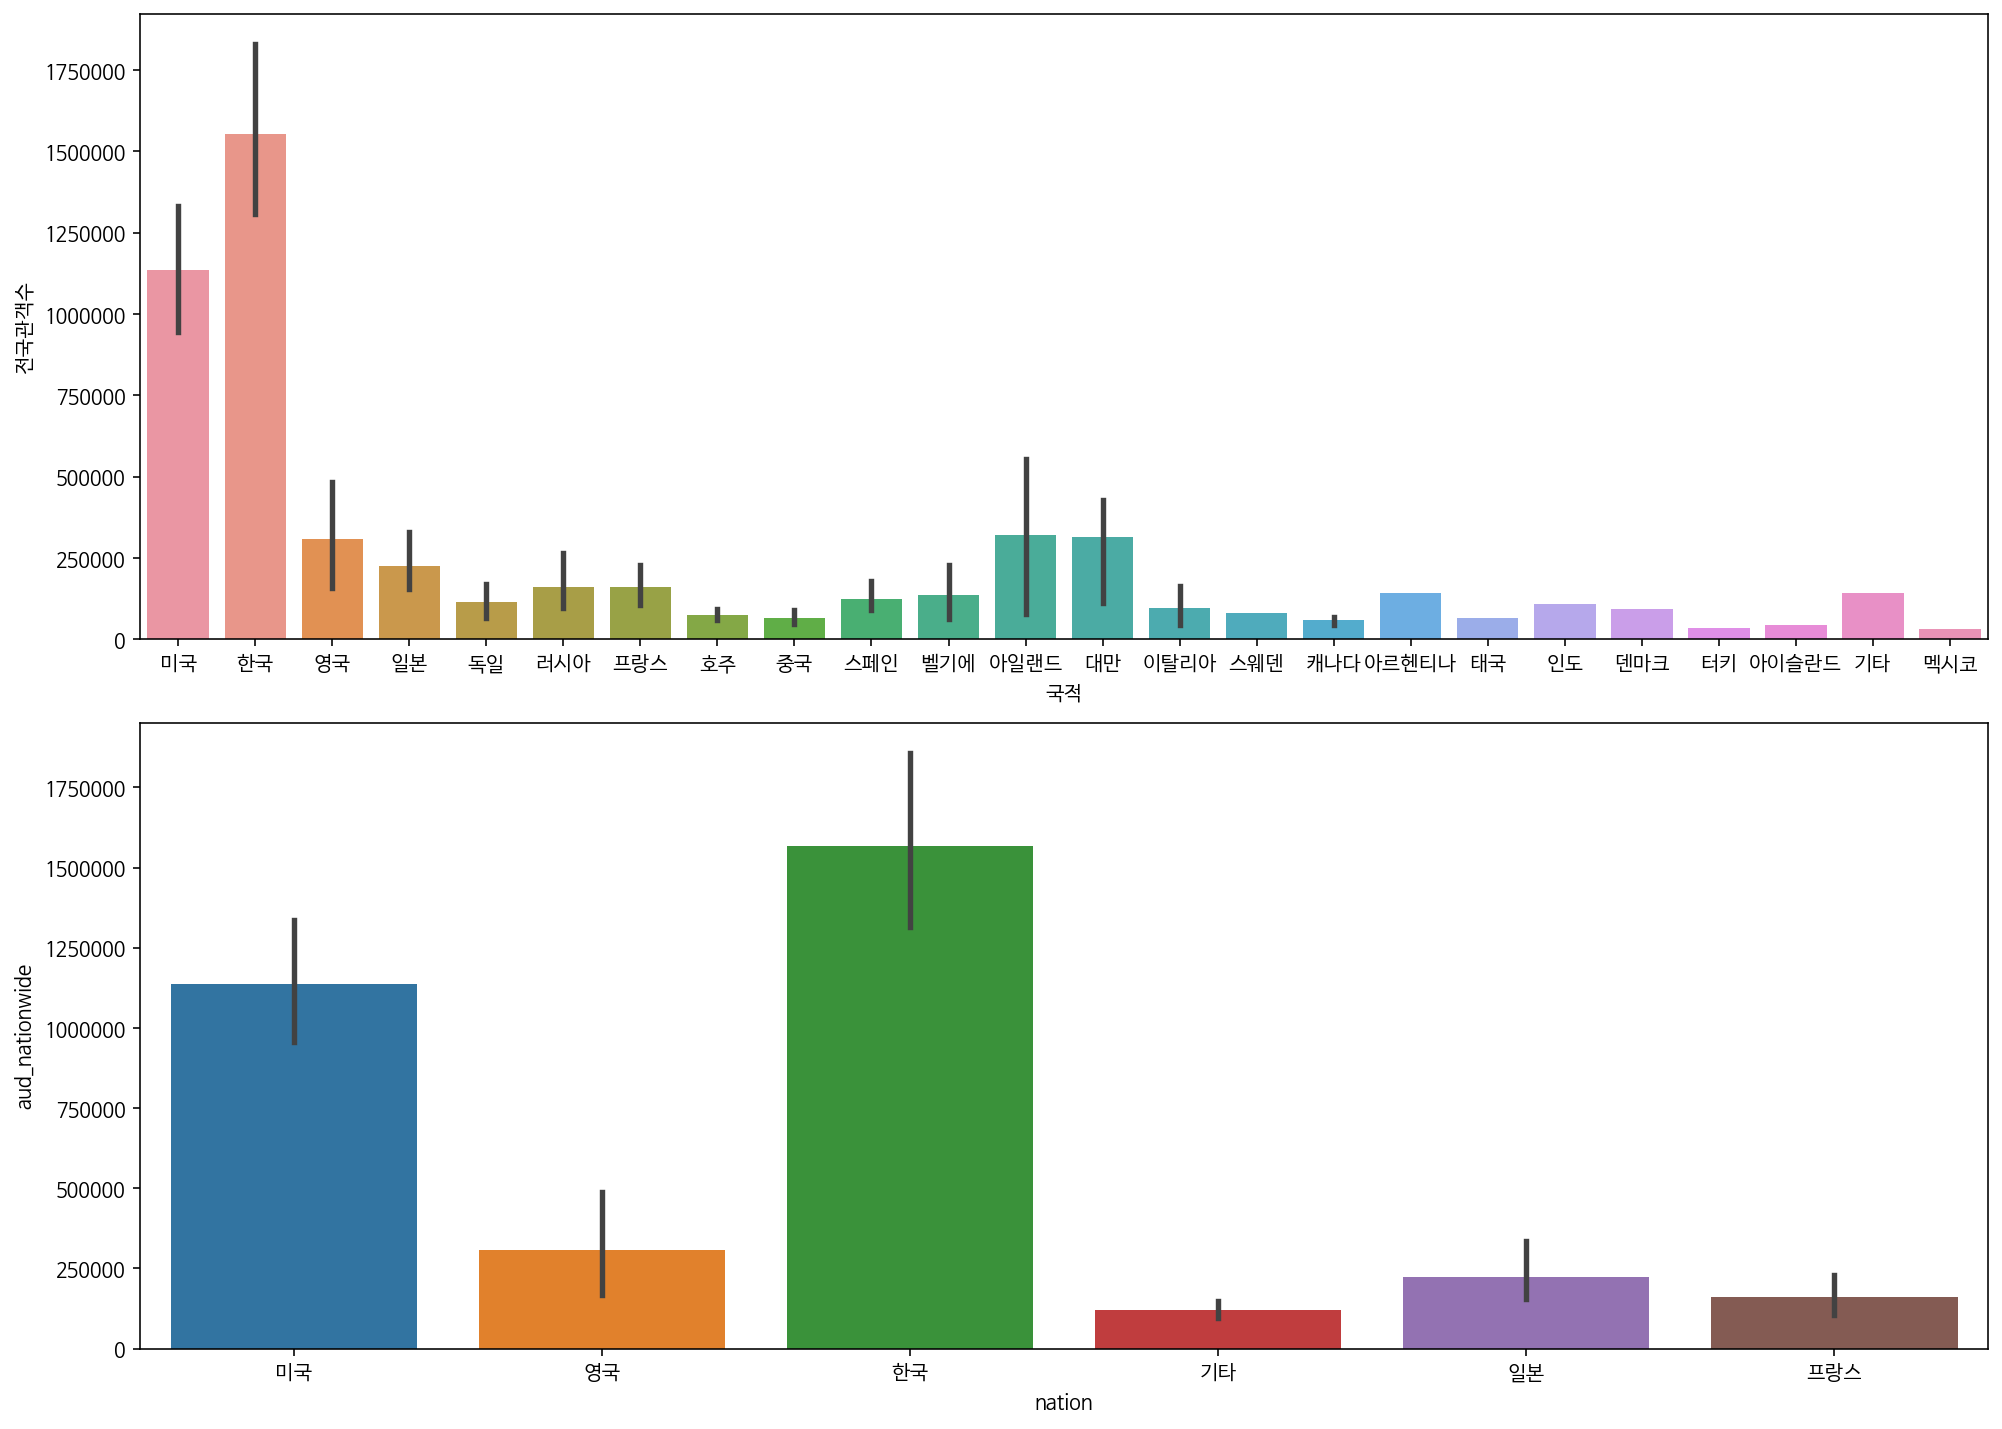

In [96]:
#### 국적 정리
plt.figure(figsize=(14, 10))

plt.subplot(211)
sns.barplot(x=df_final_03["국적"], y=df_final_03["전국관객수"])

plt.subplot(212)
sns.barplot(x=df_final_09["nation"], y=df_final_09["aud_nationwide"])

plt.tight_layout()
plt.show()

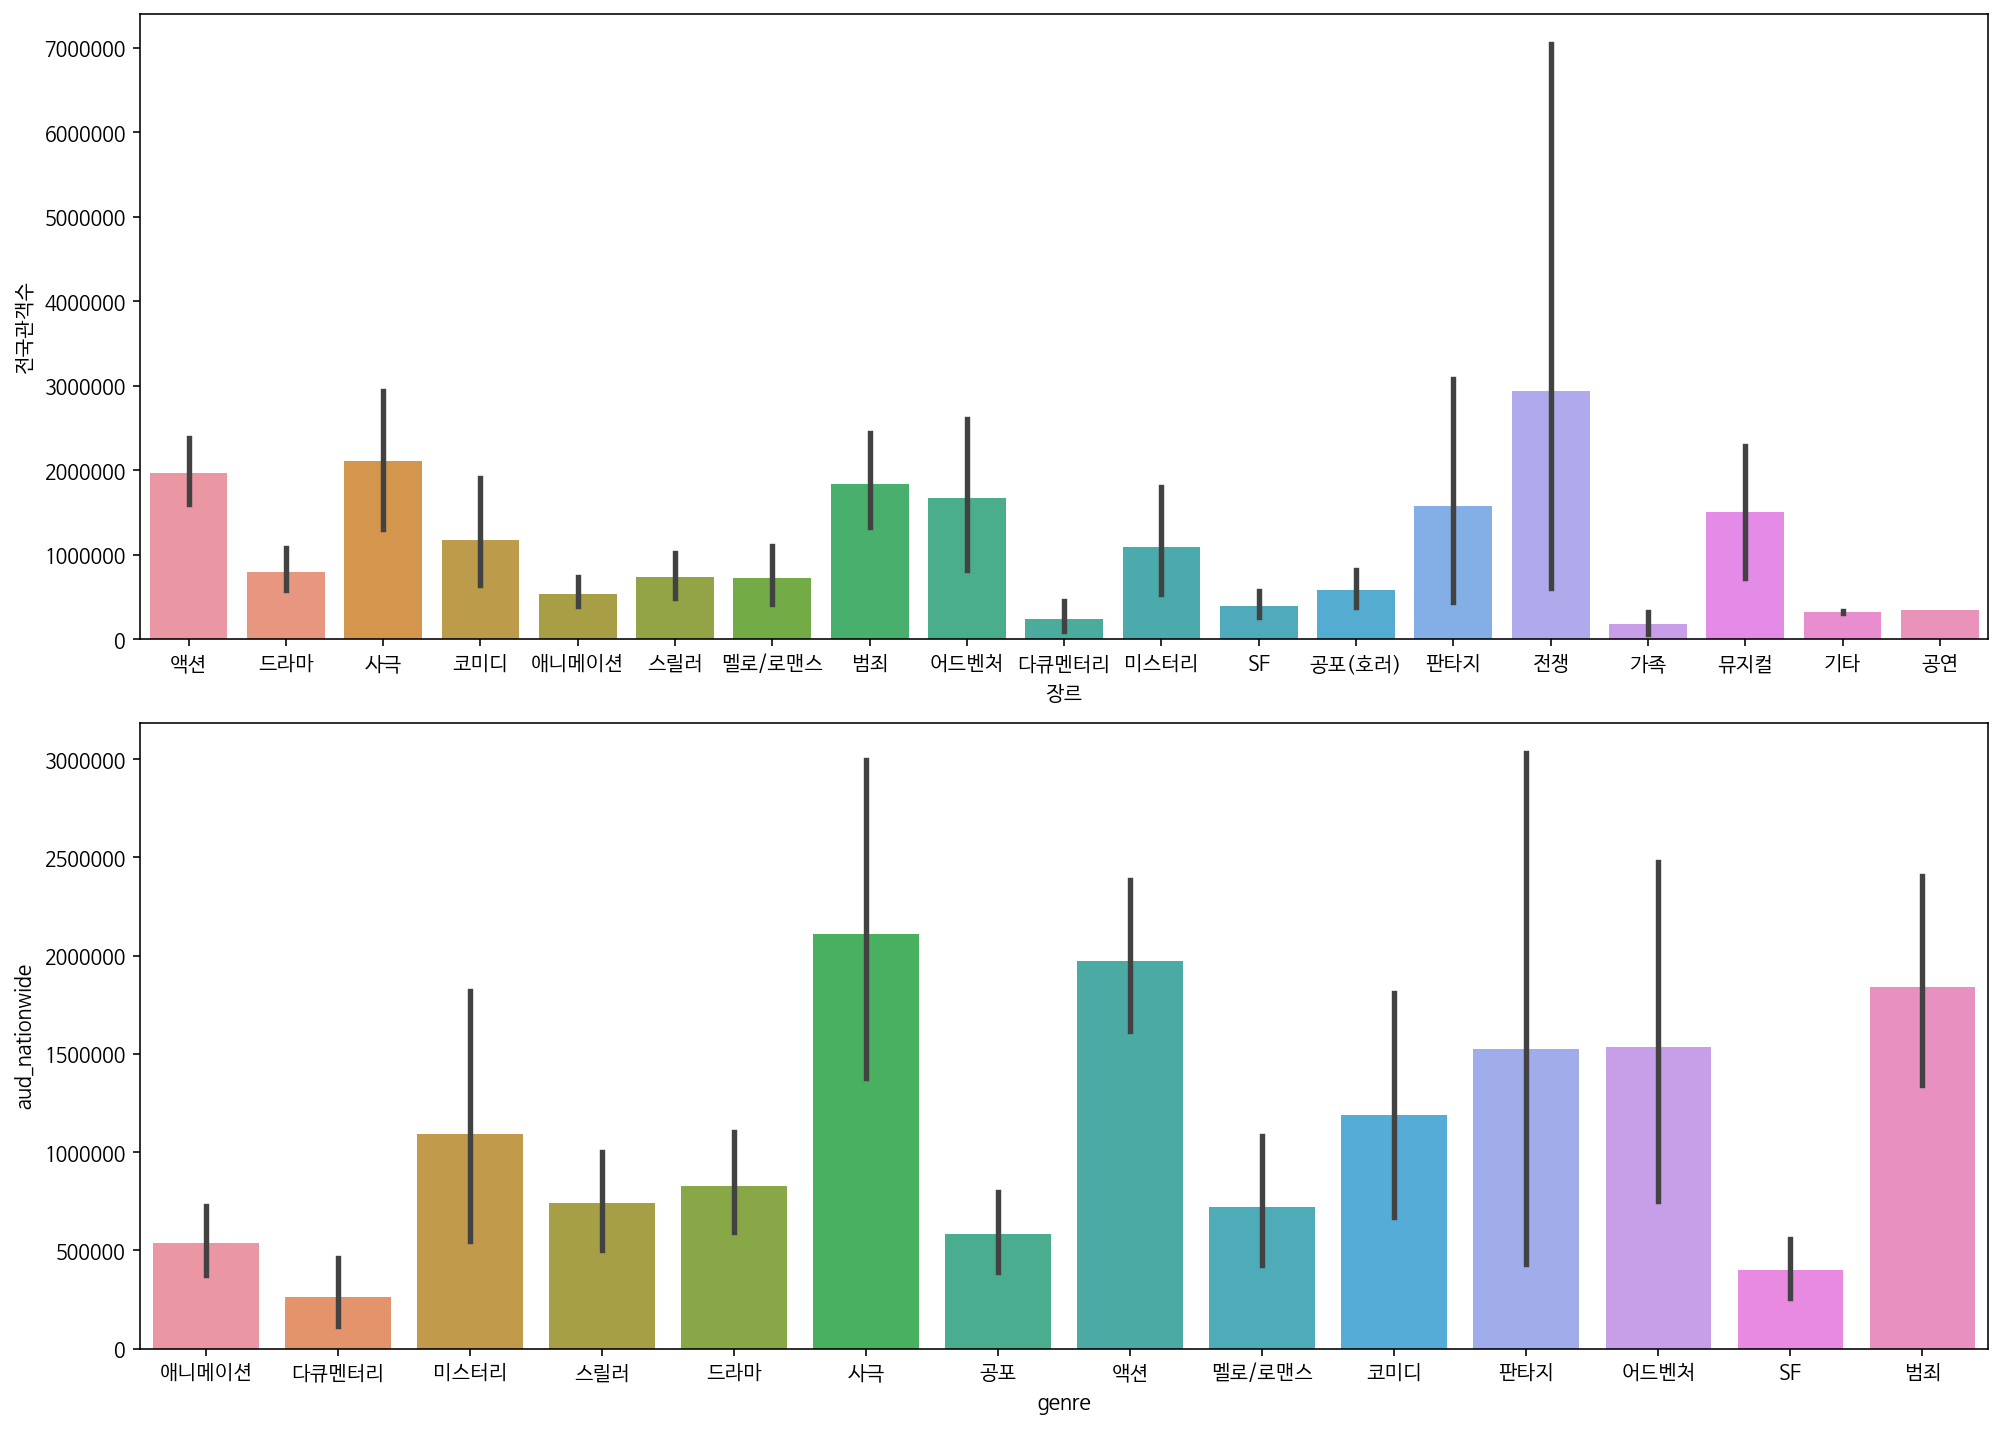

In [97]:
#### 장르 정리
plt.figure(figsize=(14, 10))

plt.subplot(211)
sns.barplot(x=df_final_03["장르"], y=df_final_03["전국관객수"])

plt.subplot(212)
sns.barplot(x=df_final_09["genre"], y=df_final_09["aud_nationwide"])

plt.tight_layout()
plt.show()

#### sequel & original 컬럼 추가

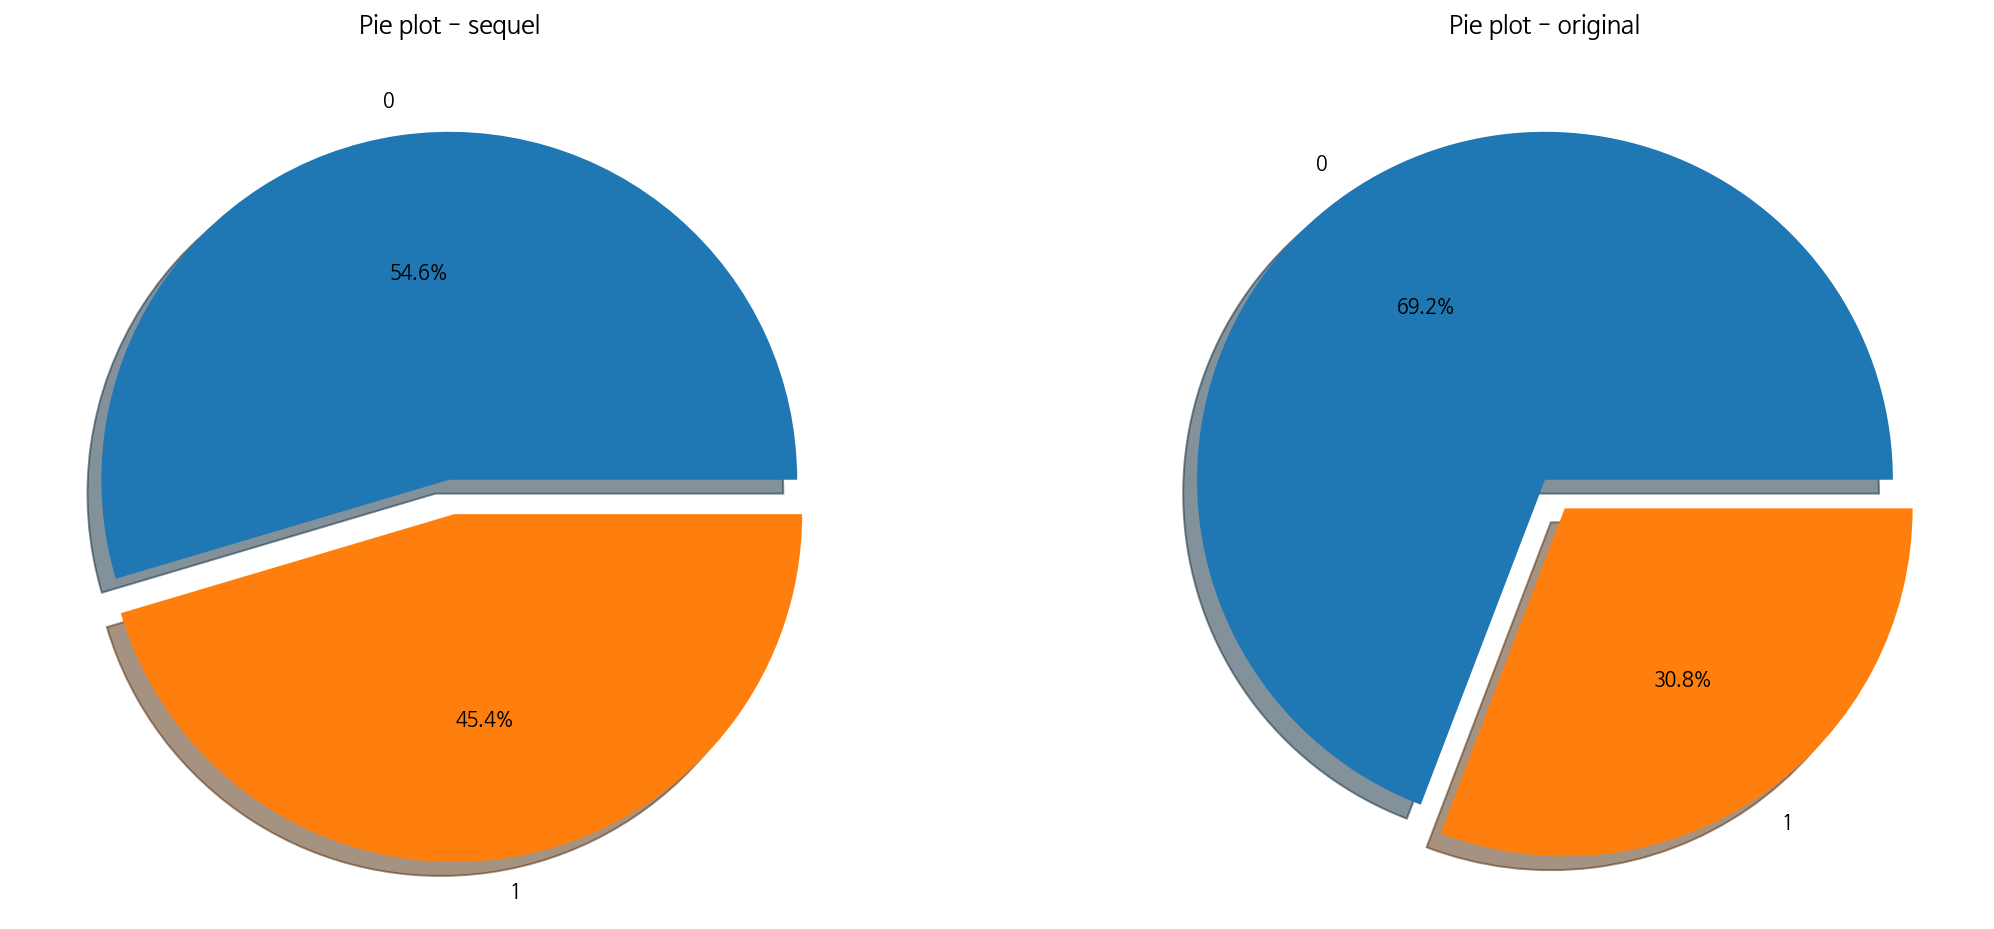

In [98]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_final_09['sequel'].value_counts().plot.pie(explode=[0, 0.1],
                                                  autopct='%1.1f%%', ax=ax[0], shadow=True)
df_final_09['original'].value_counts().plot.pie(explode=[0, 0.1],
                                                   autopct='%1.1f%%', ax=ax[1], shadow=True)
ax[0].set_title('Pie plot - sequel')
ax[0].set_ylabel('')
ax[1].set_title('Pie plot - original')
ax[1].set_ylabel('')

plt.show()

#### director_power & actor_power 수치화

In [103]:
df_final_03.head(1)

,id,영화명,감독,제작사,수입사,배급사,개봉일,영화유형,영화형태,국적,...,등급,영화구분,expert_rating,starring_actors,running_times,audience_rating,rating_audiences,개봉일_int,director_power,director_movie_num
0,0,어벤져스: 에이지 오브 울트론,조스 웨던,NaN,월트디즈니컴퍼니코리아(주),월트디즈니컴퍼니코리아(주),2015-04-23,개봉영화,장편,미국,...,12세이상관람가,일반영화,6.92,"로버트 다우니 주니어(토니 스타크 / 아이언맨), 크리스 헴스워스(토르), 마크 러...",141,8.612377,5268,2015,17567536.0,1 [1]


In [122]:
df_director_power = pd.read_csv("../linear_regression_project/yeejun/director_compare_df.csv").drop(columns='Unnamed: 0')
df_director_power[df_director_power['감독'] == '조스 웨던'][["영화명", "감독", "개봉일", "관객수"]]

,영화명,감독,개봉일,관객수
0,어벤져스,조스 웨던,2012-04-26,7073037
400,어벤져스: 에이지 오브 울트론,조스 웨던,2015-04-23,10494499


In [123]:
sum(df_director_power[df_director_power['감독'] == '조스 웨던']["관객수"])

17567536

#### 최종 데이터
카테고리 변수 중 감독(2개), 배급사(1개) 결측 데이터 제거 후 총 925개

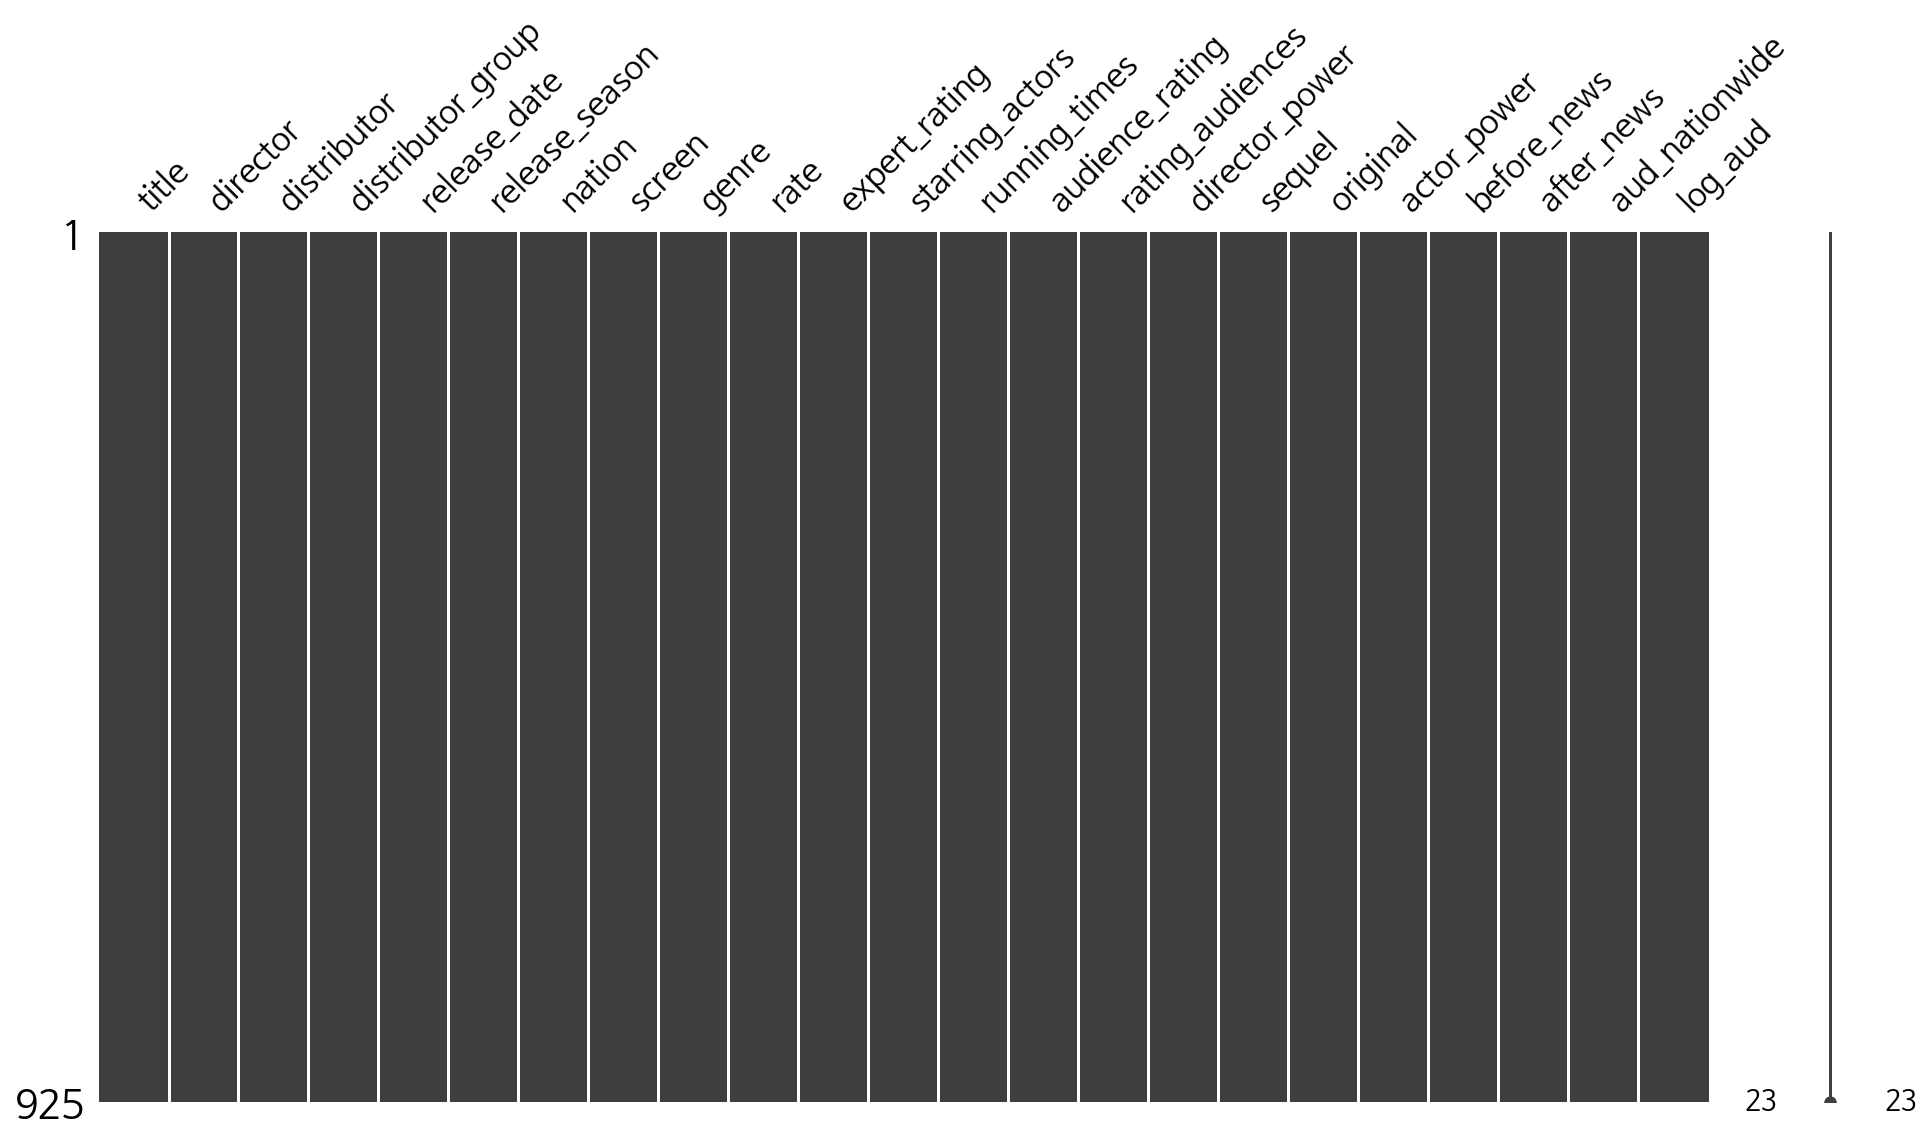

In [129]:
msno.matrix(df, figsize=(16, 8))
plt.show()

In [130]:
df.describe()

,screen,expert_rating,running_times,audience_rating,rating_audiences,director_power,sequel,original,actor_power,before_news,after_news,aud_nationwide,log_aud
count,925.000000,925.000000,925.000000,925.000000,925.000000,9.250000e+02,925.000000,925.000000,9.250000e+02,9.250000e+02,925.000000,9.250000e+02,925.000000
mean,615.031351,5.400735,109.778378,8.166960,673.470270,3.755600e+06,0.454054,0.308108,8.945175e+07,9.176964e+04,613.630270,1.099422e+06,12.765999
std,419.167442,2.048343,19.932613,1.492485,1386.145334,1.252446e+07,0.498154,0.461961,1.498437e+08,4.481563e+05,1205.564874,2.009962e+06,1.500650
min,28.000000,0.000000,48.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,3.186600e+04,10.369295
25%,322.000000,5.000000,97.000000,7.867150,81.000000,1.502150e+05,0.000000,0.000000,4.066096e+06,8.580000e+02,95.000000,9.701700e+04,11.482641
50%,512.000000,5.920000,110.000000,8.457944,234.000000,8.145870e+05,0.000000,0.000000,2.987306e+07,4.193000e+03,279.000000,2.860420e+05,12.563894
75%,827.000000,6.700000,122.000000,8.919948,696.000000,3.417629e+06,1.000000,1.000000,1.003499e+08,1.743900e+04,688.000000,1.124815e+06,13.933129
max,2835.000000,9.110000,222.000000,10.000000,24610.000000,1.989550e+08,1.000000,1.000000,1.151033e+09,6.013797e+06,17083.000000,1.626336e+07,16.604425


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 23 columns):
title                925 non-null object
director             925 non-null object
distributor          925 non-null object
distributor_group    925 non-null object
release_date         925 non-null object
release_season       925 non-null object
nation               925 non-null object
screen               925 non-null int64
genre                925 non-null object
rate                 925 non-null object
expert_rating        925 non-null float64
starring_actors      925 non-null object
running_times        925 non-null int64
audience_rating      925 non-null float64
rating_audiences     925 non-null int64
director_power       925 non-null float64
sequel               925 non-null int64
original             925 non-null int64
actor_power          925 non-null int64
before_news          925 non-null float64
after_news           925 non-null float64
aud_nationwide       925 non-null i

### 3. 상관관계 조사

#### pairplot

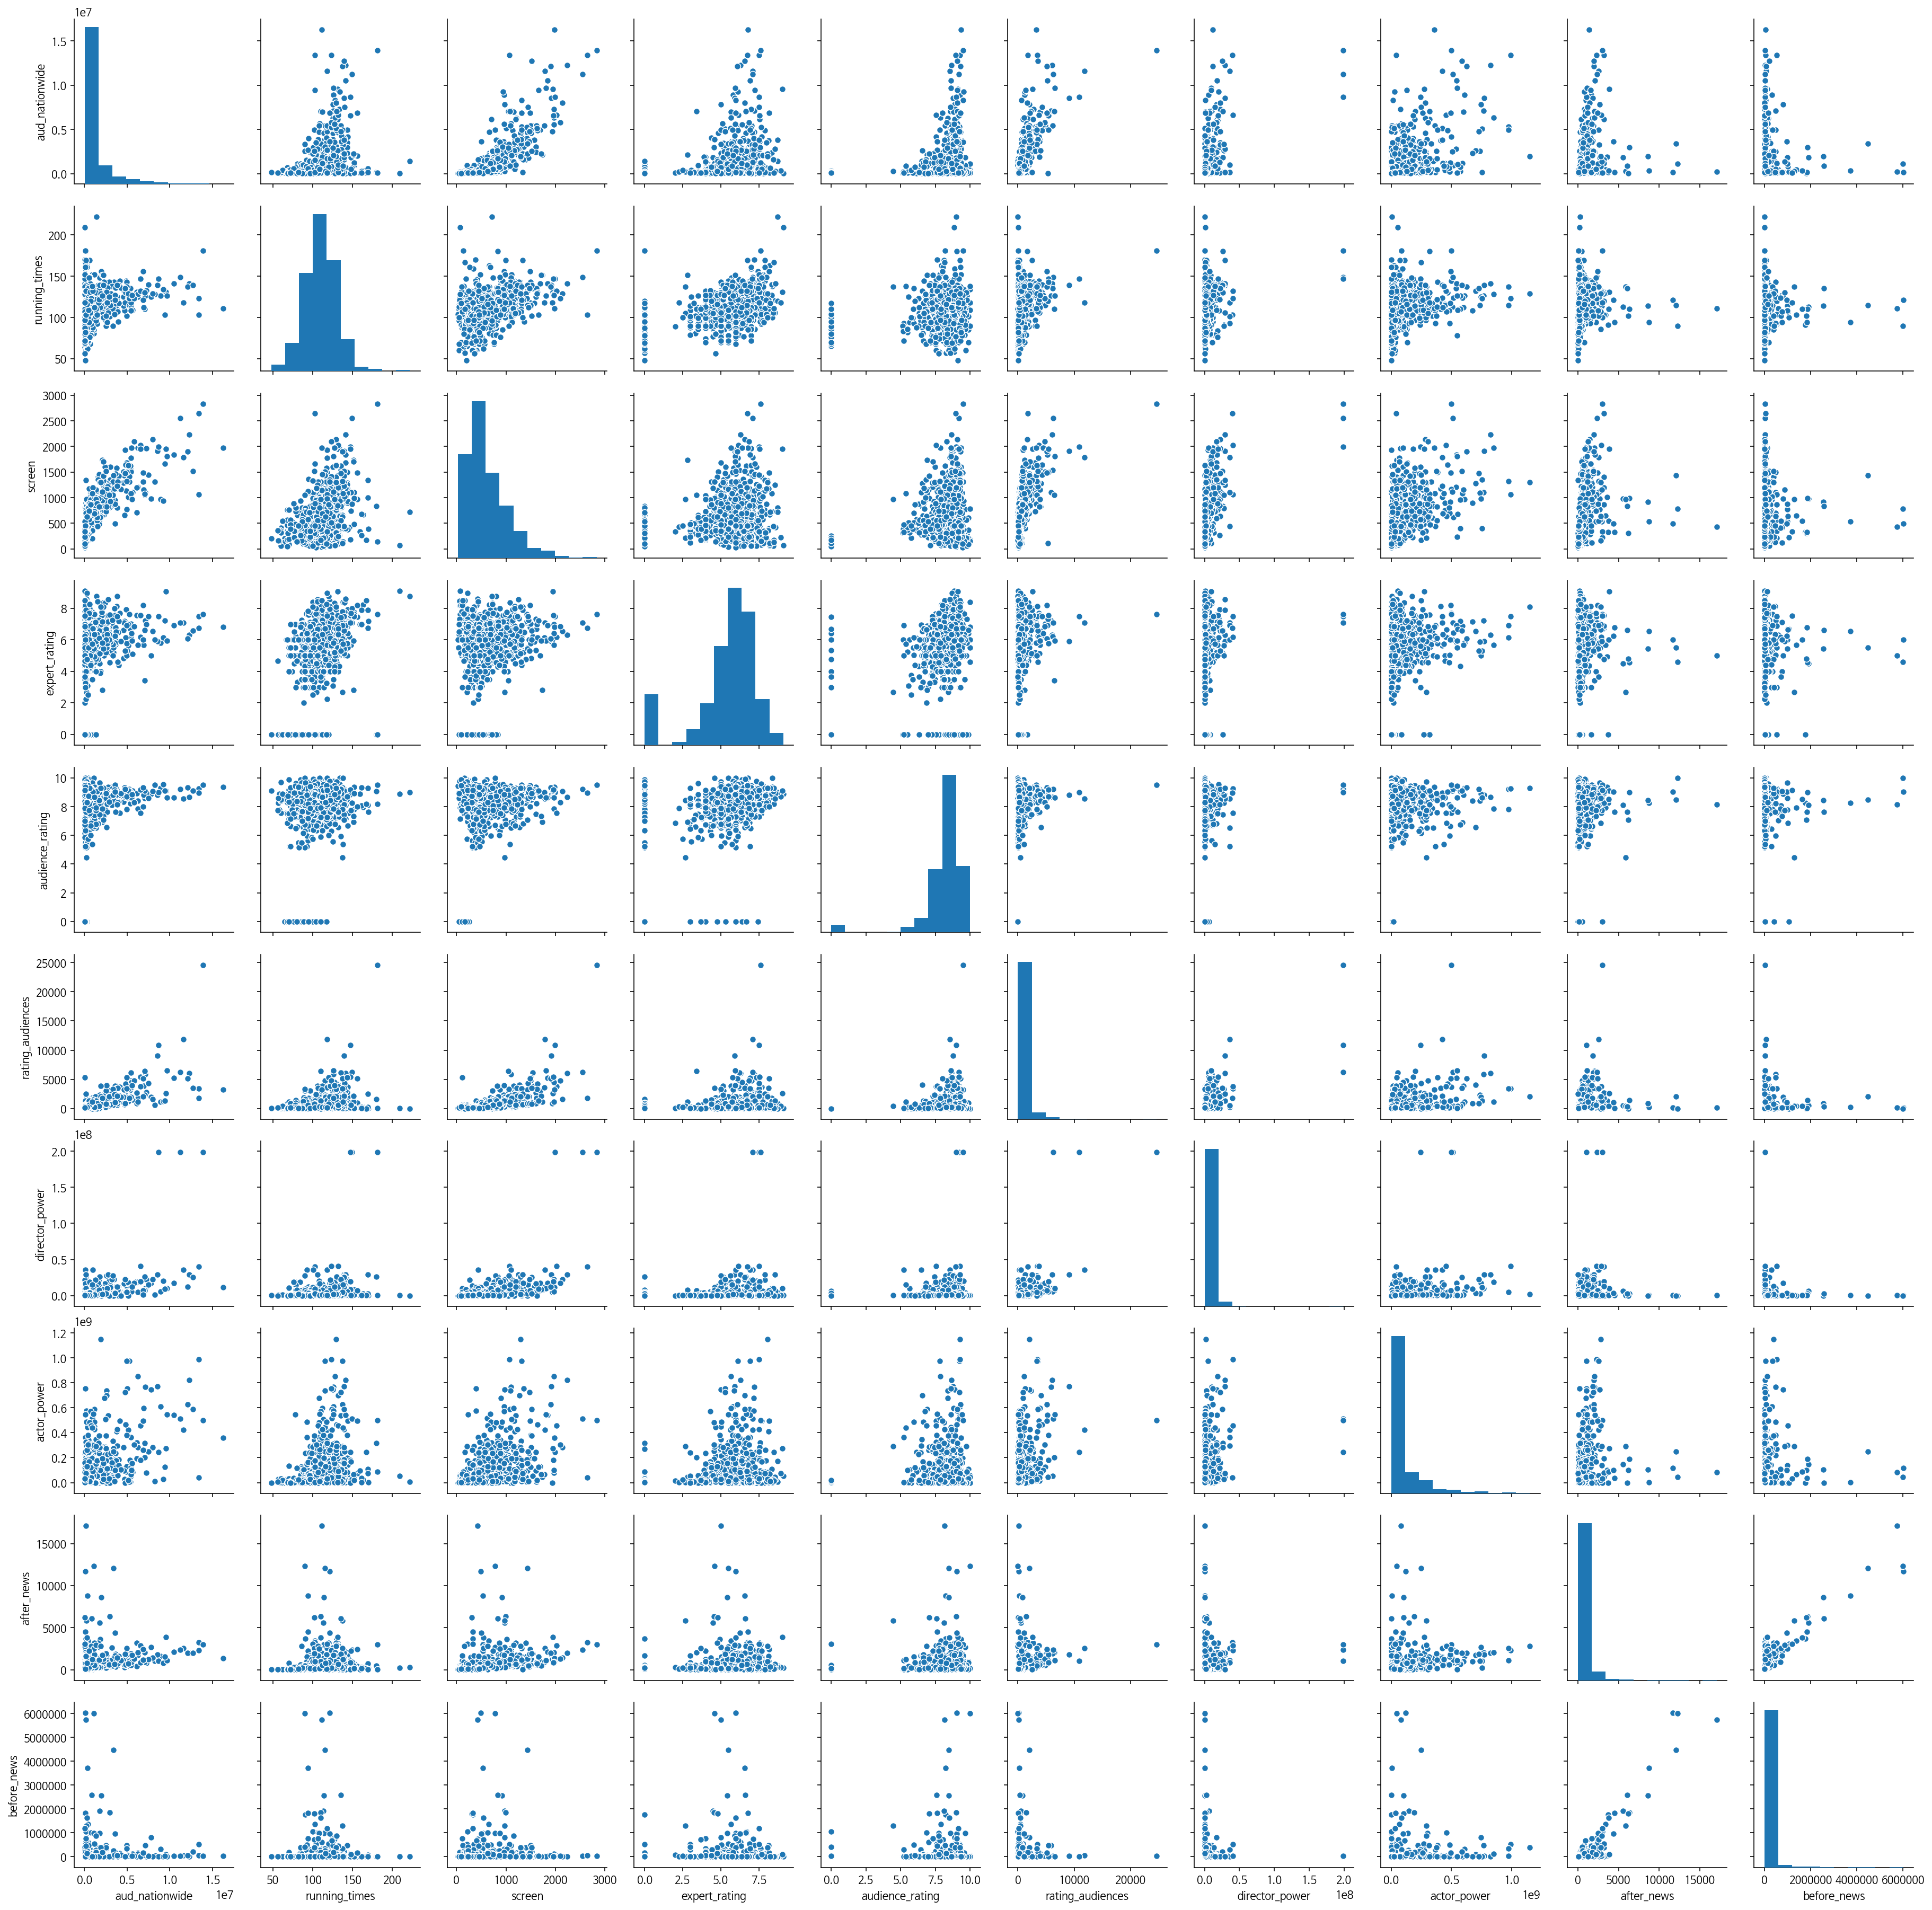

In [134]:
sns.pairplot(df[['aud_nationwide', 'running_times', 'screen', 'expert_rating', 'audience_rating', 'rating_audiences', 'director_power', 'actor_power', 'after_news', 'before_news']])
plt.show()

#### 히트맵으로 수치형 데이터 상관관계 파악
- 스크린수(screen)와 평점을 매긴 관객수(rating_audiensces)가 관객수(aud_nationwide)와 높은 상관관계를 갖는다.
- 개봉전 뉴스 건수(before_news)와 관객수(aud_nationwide)는 상관계수가 0이다.
- 감독파워(director_power), 스타파워(actor_power)는 관객수와 상관계수가 0.5이다.
- 평점을 매긴 관객수(rating_audiences)와 스크린수(screen)의 상관계수가 0.7이다. (다중공선성 주의)
- 개봉전 기사 건수(before_news)와 개봉후 기사 건수(after_news)의 상관계수가 0.9이다. (다중공선성 주의)
- 평점을 매긴 관객수(audience_rating)와 감독파워(director_power)의 상관계수가 0.7이다. (다중공선성 주의)

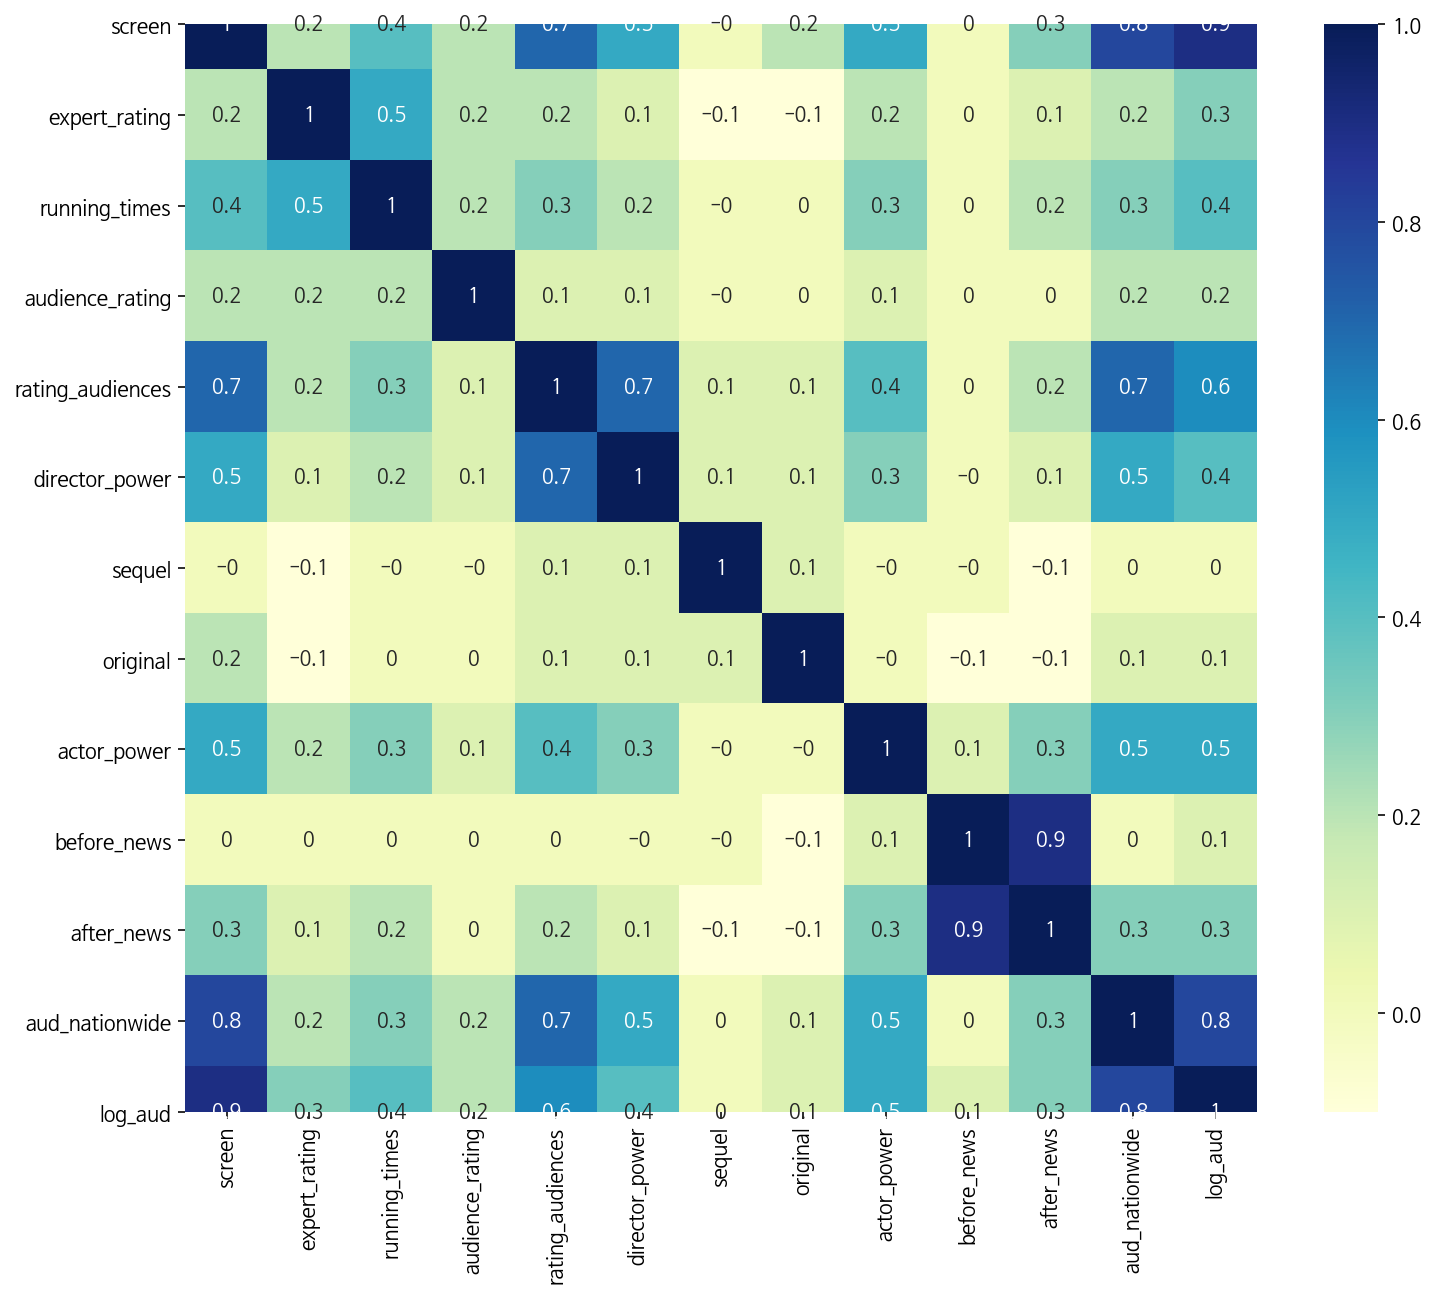

In [143]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr().round(1)
sns.heatmap(data=correlation_matrix, annot=True, cmap="YlGnBu")
plt.show()

#### 카테고리 변수화 전국관객수와의 관계 파악

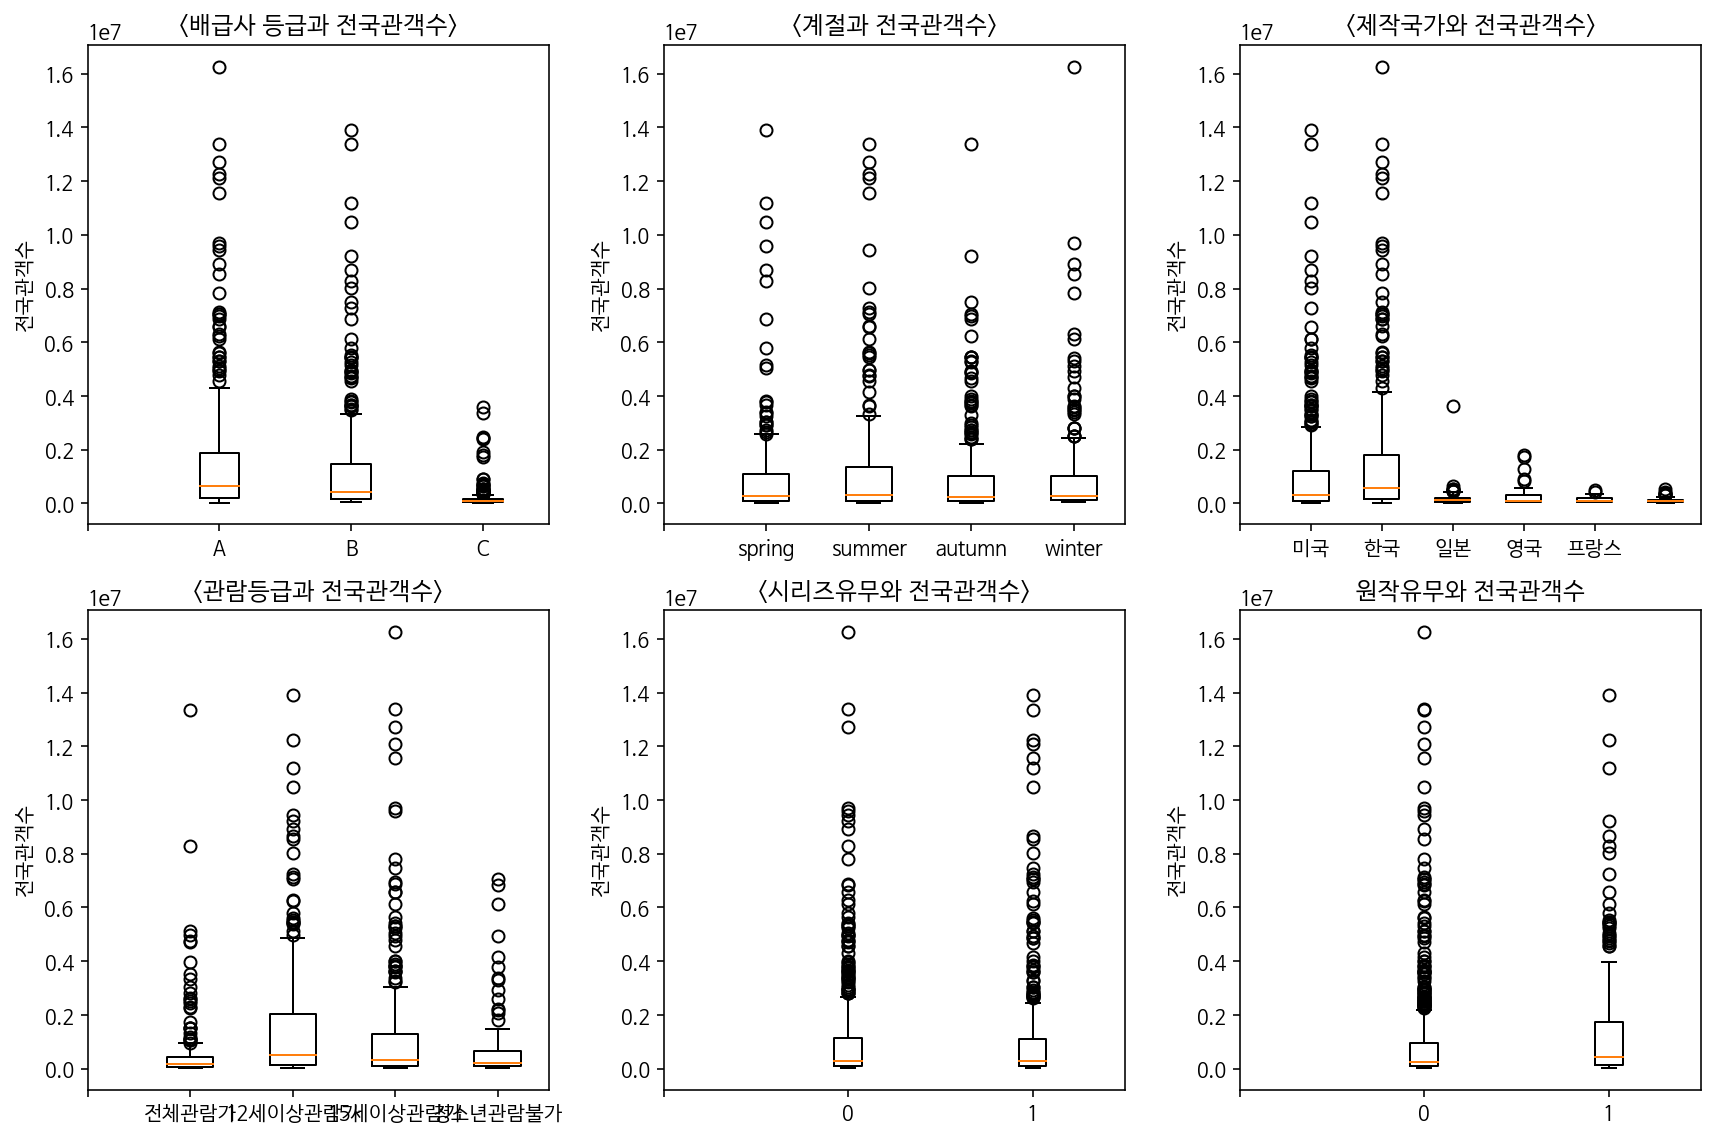

In [135]:
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.boxplot((df[df['distributor_group'] == 'A']['aud_nationwide'], df[df['distributor_group'] == 'B']['aud_nationwide'], 
             df[df['distributor_group'] == 'C']['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(4), (' ', 'A', 'B', 'C'))
plt.title("<배급사 등급과 전국관객수>")

plt.subplot(232)
plt.boxplot((df[df['release_season'] == 'spring']['aud_nationwide'], df[df['release_season'] == 'summer']['aud_nationwide'], 
             df[df['release_season'] == 'autumn']['aud_nationwide'], df[df['release_season'] == 'winter']['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(5), (' ', 'spring', 'summer', 'autumn', 'winter'))
plt.title("<계절과 전국관객수>")

plt.subplot(233)
plt.boxplot((df[df['nation'] == '미국']['aud_nationwide'], df[df['nation'] == '한국']['aud_nationwide'], df[df['nation'] == '일본']['aud_nationwide'],
            df[df['nation'] == '영국']['aud_nationwide'], df[df['nation'] == '프랑스']['aud_nationwide'], df[df['nation'] == '기타']['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(6), (' ', '미국', '한국', '일본', '영국', '프랑스', '기타'))
plt.title("<제작국가와 전국관객수>")

plt.subplot(234)
plt.boxplot((df[df['rate'] == '전체관람가']['aud_nationwide'], df[df['rate'] == '12세이상관람가']['aud_nationwide'], 
             df[df['rate'] == '15세이상관람가']['aud_nationwide'], df[df['rate'] == '청소년관람불가']['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(5), (' ', '전체관람가', '12세이상관람가', '15세이상관람가', '청소년관람불가'))
plt.title("<관람등급과 전국관객수>")

plt.subplot(235)
plt.boxplot((df[df['sequel'] == 0]['aud_nationwide'], df[df['sequel'] == 1]['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(3), (' ', '0', '1'))
plt.title("<시리즈유무와 전국관객수>")

plt.subplot(236)
plt.boxplot((df[df['original'] == 0]['aud_nationwide'], df[df['original'] == 1]['aud_nationwide']))
plt.ylabel("전국관객수")
plt.xticks(np.arange(3), (' ', '0', '1'))
plt.title("원작유무와 전국관객수")

plt.tight_layout ()
plt.show()

#### 카테고리 변수들간 상관관계 히트맵

In [137]:
dist_df = pd.get_dummies(df['distributor_group'], prefix='dist')
season_df = pd.get_dummies(df['release_season'], prefix='season')
nation_df = pd.get_dummies(df['nation'], prefix='nation')
rate_df = pd.get_dummies(df['rate'], prefix='rate')
sequel_df = pd.get_dummies(df['sequel'], prefix='sequel')
original_df  = pd.get_dummies(df['original'], prefix='original')
genre_df = pd.get_dummies(df['genre'], prefix='genre')

dummies_df = pd.concat((dist_df, season_df, nation_df, rate_df, sequel_df, original_df, genre_df), axis=1)


correlation_matrix_cat = dummies_df.corr().round(1)

- 한국과 미국 -0.7 (경쟁관계)
- 애니메이션 전체관람가 0.8 / 애니메이션과 일본 0.4
- 상영시간과 전체관람가 0.5 / 상영시간과 애니메이션 0.5

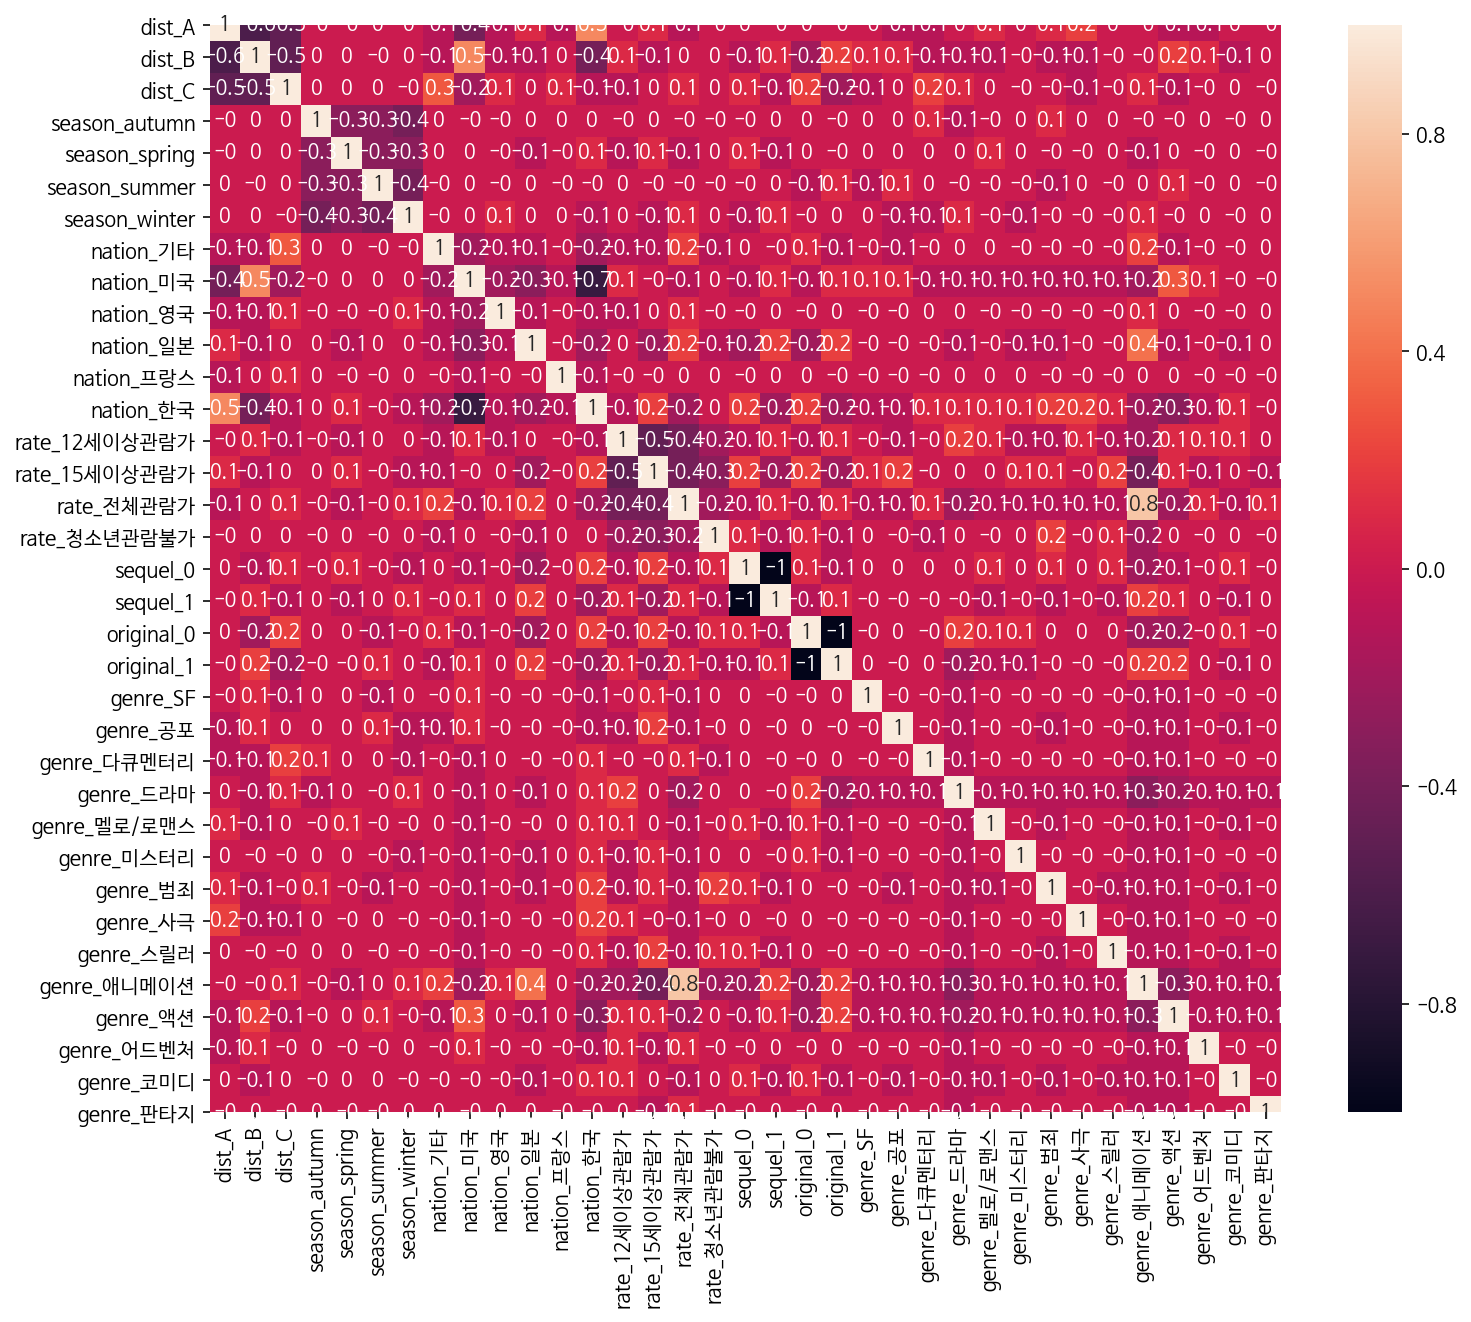

In [142]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=correlation_matrix_cat, annot=True)
plt.show()

### 가설:
#### 배우파워가 관객수에 가장 영향을 많이 줄 것이다
#### 영화의 흥행도는 개봉 후 바이럴마케팅(네이버 기사 수, 네이버 평점, 입소문)의 영향이 크다

### 4. 선형회귀 OLS

#### train-test set 분리 8:2

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
title                740 non-null object
director             740 non-null object
distributor          740 non-null object
distributor_group    740 non-null object
release_date         740 non-null object
release_season       740 non-null object
nation               740 non-null object
screen               740 non-null int64
genre                740 non-null object
rate                 740 non-null object
expert_rating        740 non-null float64
starring_actors      740 non-null object
running_times        740 non-null int64
audience_rating      740 non-null float64
rating_audiences     740 non-null int64
director_power       740 non-null float64
sequel               740 non-null int64
original             740 non-null int64
actor_power          740 non-null int64
before_news          740 non-null float64
after_news           740 non-null float64
dtypes: float64(5), int64(6), objec

In [145]:
kfold_dict = {}
kfold_dict_avr = []
kfold_df = pd.DataFrame()

# model0
- 아무 처리 안한 원본
- 16개의 독립변수 모두 사용

In [147]:
df0 = df.copy()

In [148]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'rating_audiences', 'director_power', 'actor_power', 'before_news', 'after_news']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model0 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df0)
result0 = model0.fit()
print(result0.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     58.62
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          5.47e-188
Time:                        12:44:51   Log-Likelihood:                -11275.
No. Observations:                 740   AIC:                         2.263e+04
Df Residuals:                     702   BIC:                         2.280e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [149]:
# kfold 0

from sklearn.model_selection import KFold

kfold_dict['0'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df0)):
    df_train = df0.iloc[idx_train]
    df_test = df0.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['0'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['0'])/10)

학습 R2 = 0.78390876, 검증 R2 = 0.78528260
학습 R2 = 0.78648920, 검증 R2 = 0.75103586
학습 R2 = 0.78673211, 검증 R2 = 0.66727676
학습 R2 = 0.78837056, 검증 R2 = 0.74479025
학습 R2 = 0.78611346, 검증 R2 = 0.76045370
학습 R2 = 0.78815483, 검증 R2 = 0.73940537
학습 R2 = 0.78989304, 검증 R2 = 0.70998676
학습 R2 = 0.78783934, 검증 R2 = 0.74646547
학습 R2 = 0.78425455, 검증 R2 = 0.77823270
학습 R2 = 0.78765667, 검증 R2 = 0.74294697


In [150]:
# model0의 테스트 R

pred = result0.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7005251184088559

# model1
- 종속변수에 log 

In [151]:
df1 = df0.copy()

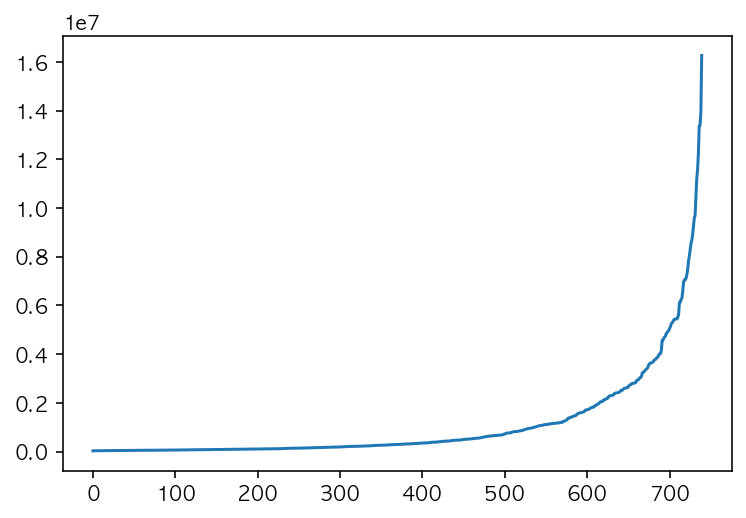

In [152]:
plt.plot(df1['aud_nationwide'].sort_values().reset_index(drop=True))

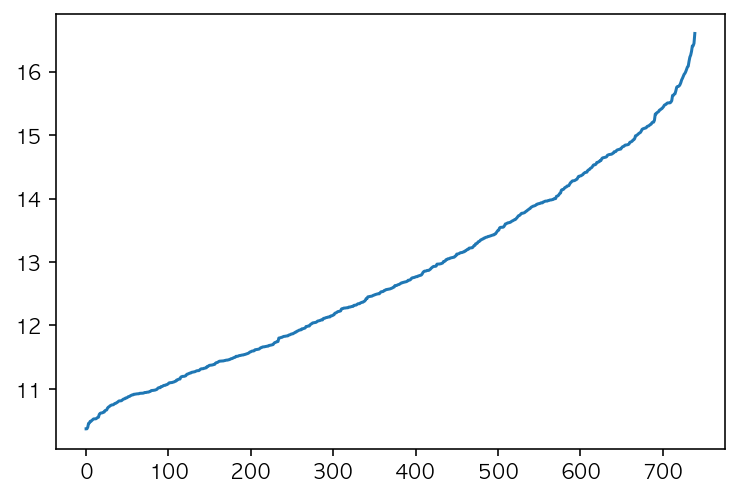

In [153]:
plt.plot(np.log(df1['aud_nationwide'].sort_values().reset_index(drop=True)))

In [154]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'rating_audiences', 'director_power', 'actor_power', 'before_news', 'after_news']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model1 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     69.36
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          1.86e-207
Time:                        12:45:03   Log-Likelihood:                -778.47
No. Observations:                 740   AIC:                             1633.
Df Residuals:                     702   BIC:                             1808.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [155]:
# kfold 1

from sklearn.model_selection import KFold

kfold_dict['1'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df1)):
    df_train = df1.iloc[idx_train]
    df_test = df1.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['1'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['1'])/10)


학습 R2 = 0.78390876, 검증 R2 = 0.78528260
학습 R2 = 0.78648920, 검증 R2 = 0.75103586
학습 R2 = 0.78673211, 검증 R2 = 0.66727676
학습 R2 = 0.78837056, 검증 R2 = 0.74479025
학습 R2 = 0.78611346, 검증 R2 = 0.76045370
학습 R2 = 0.78815483, 검증 R2 = 0.73940537
학습 R2 = 0.78989304, 검증 R2 = 0.70998676
학습 R2 = 0.78783934, 검증 R2 = 0.74646547
학습 R2 = 0.78425455, 검증 R2 = 0.77823270
학습 R2 = 0.78765667, 검증 R2 = 0.74294697


In [156]:
# model1의 테스트 R

pred = result1.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.75232013370038

# model2
- 뉴스기사 컬럼에 대한 처리

In [157]:
df2 = df1.copy()

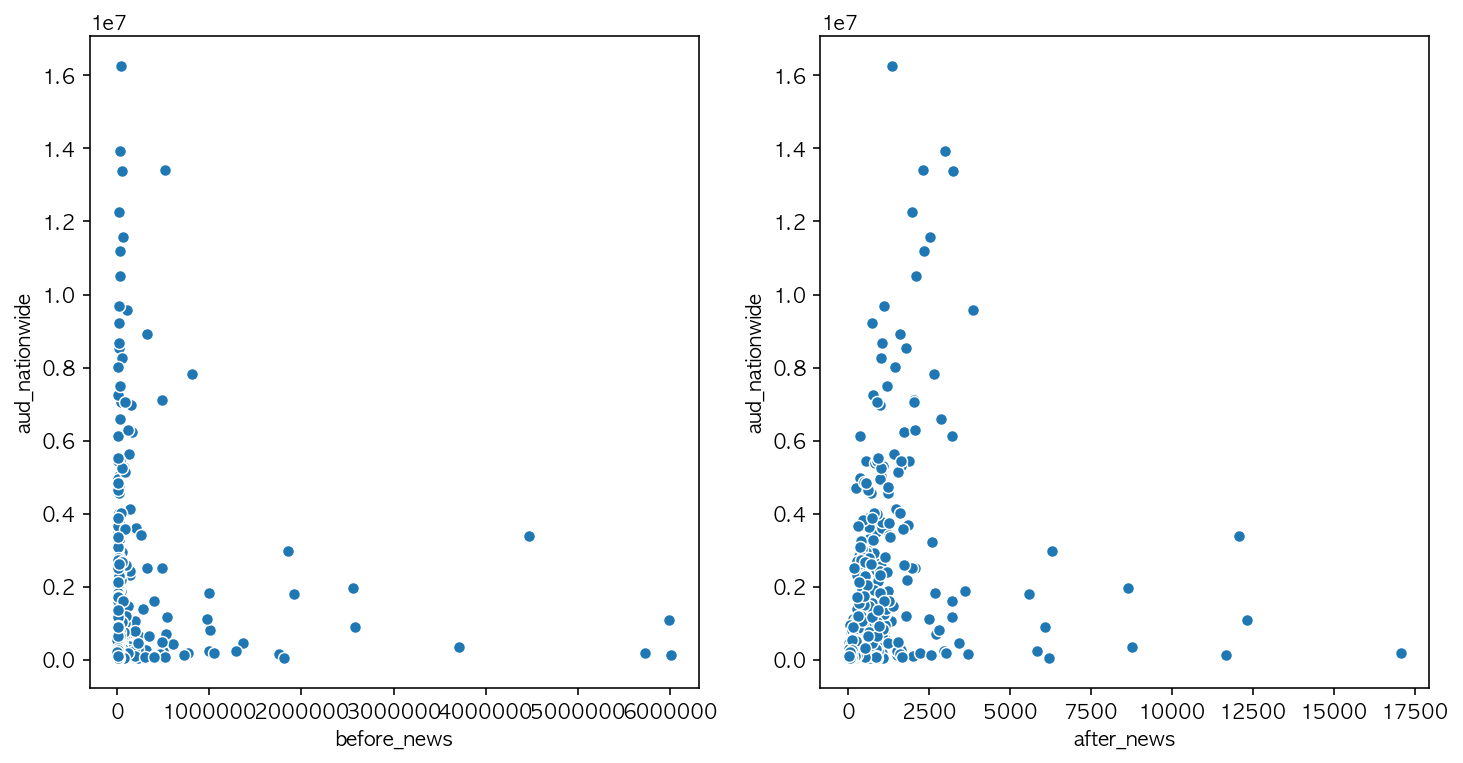

In [158]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="before_news", y="aud_nationwide", data=df2)
plt.subplot(122)
sns.scatterplot(x="after_news", y="aud_nationwide", data=df2)
plt.show()

In [159]:
df2_1 = df2.copy()

In [160]:
# 로그 취한값에 다시 루트 씌우기

df2_1['log_sqrt_before_news'] = df2_1['before_news'].apply(
    lambda news: np.sqrt(np.log(news)))
df2_1['log_sqrt_after_news'] = df2_1['after_news'].apply(
    lambda news: np.sqrt(np.log(news)))

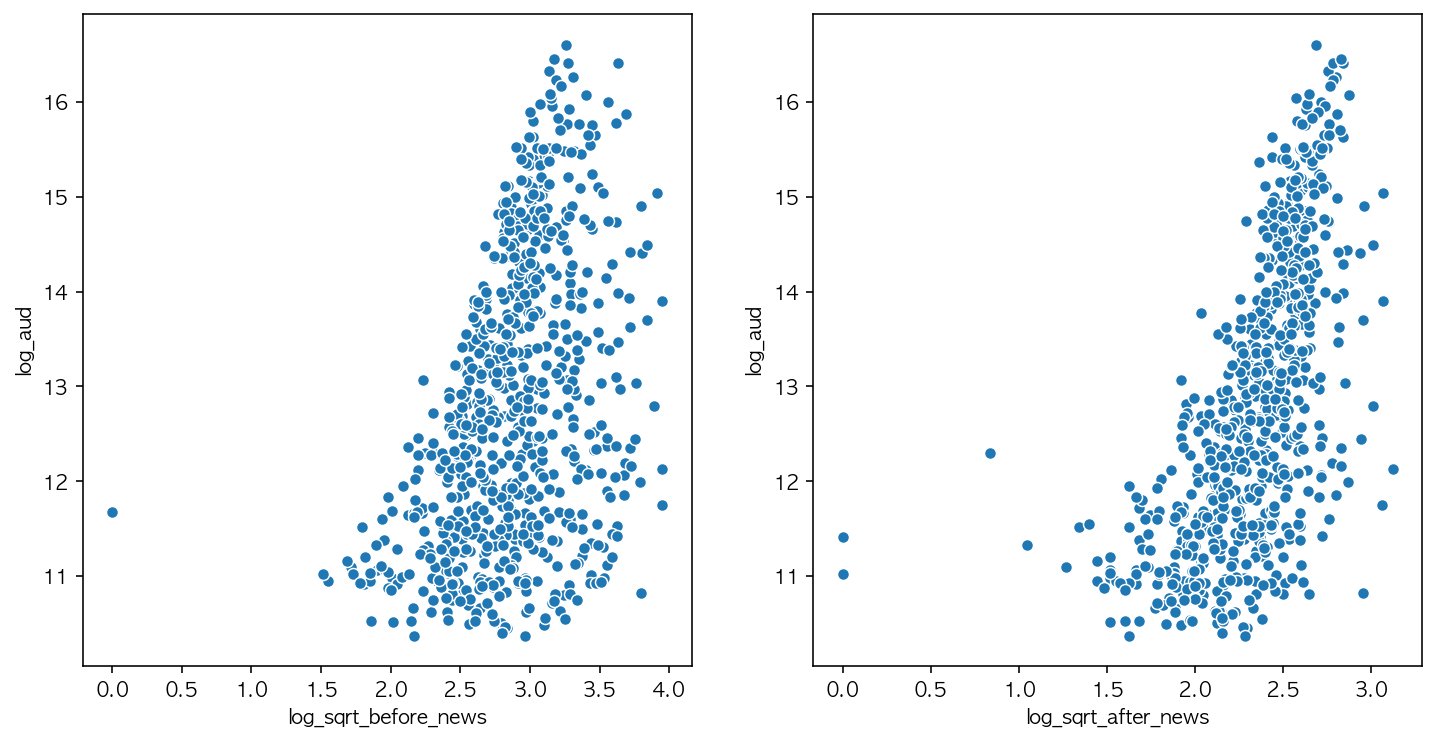

In [161]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="log_sqrt_before_news", y="log_aud", data=df2_1)
plt.subplot(122)
sns.scatterplot(x="log_sqrt_after_news", y="log_aud", data=df2_1)
plt.show()

In [162]:
df2['after_news_0to1'] = df2['after_news'].apply(
    lambda num: num if num > 0 else 1.0)

In [163]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences',
                 'director_power', 'actor_power', 'np.sqrt(np.log(before_news))', 'np.sqrt(np.log(after_news_0to1))']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model2 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     72.89
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          2.38e-213
Time:                        12:45:12   Log-Likelihood:                -763.97
No. Observations:                 740   AIC:                             1604.
Df Residuals:                     702   BIC:                             1779.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [164]:
X_test['after_news_0to1'] = X_test['after_news'].apply(
    lambda num: num if num > 0 else 1.0)

In [165]:
# kfold 2

from sklearn.model_selection import KFold

kfold_dict['2'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['2'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['2'])/10)


학습 R2 = 0.79096054, 검증 R2 = 0.80470475
학습 R2 = 0.79455470, 검증 R2 = 0.75902379
학습 R2 = 0.79627357, 검증 R2 = 0.66254370
학습 R2 = 0.79599744, 검증 R2 = 0.76002670
학습 R2 = 0.79518392, 검증 R2 = 0.75911473
학습 R2 = 0.79656699, 검증 R2 = 0.74774122
학습 R2 = 0.79675806, 검증 R2 = 0.73473402
학습 R2 = 0.79661285, 검증 R2 = 0.74848582
학습 R2 = 0.79234050, 검증 R2 = 0.78942271
학습 R2 = 0.79681040, 검증 R2 = 0.74543952


In [166]:
# model2의 테스트 R

pred = result2.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.766161021116791

# model3
- 아웃라이어 3개 제거
- 576 어벤져스: 엔드게임
- 398 캡틴 아메리카: 시빌 워
- 361 어벤져스: 인피니티 워

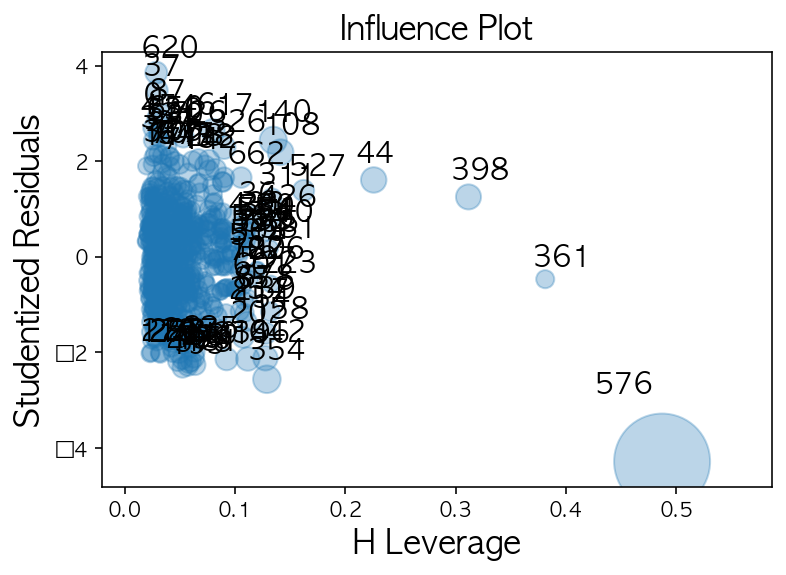

In [167]:
# Cook's distance

sm.graphics.influence_plot(result2, plot_alpha=0.3)
plt.show()

In [168]:
df3 = df2.copy()

In [169]:
df3 = df3.drop(index=[576, 398, 361])

In [170]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences',
                 'director_power', 'actor_power', 'np.sqrt(np.log(before_news))', 'np.sqrt(np.log(after_news_0to1))']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model3 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     74.12
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          7.38e-215
Time:                        12:45:24   Log-Likelihood:                -748.24
No. Observations:                 737   AIC:                             1572.
Df Residuals:                     699   BIC:                             1747.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [171]:
# kfold 3

from sklearn.model_selection import KFold

kfold_dict['3'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df3)):
    df_train = df3.iloc[idx_train]
    df_test = df3.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['3'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['3'])/10)


학습 R2 = 0.79933897, 검증 R2 = 0.74716355
학습 R2 = 0.80123473, 검증 R2 = 0.72312784
학습 R2 = 0.79609419, 검증 R2 = 0.78505577
학습 R2 = 0.79780854, 검증 R2 = 0.77360499
학습 R2 = 0.80034402, 검증 R2 = 0.75075379
학습 R2 = 0.79836103, 검증 R2 = 0.76381822
학습 R2 = 0.79696689, 검증 R2 = 0.76380003
학습 R2 = 0.79874544, 검증 R2 = 0.74363119
학습 R2 = 0.79266267, 검증 R2 = 0.81363123
학습 R2 = 0.80106878, 검증 R2 = 0.75090421


In [172]:
# model3의 테스트 R

pred = result3.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7739654530371688

# model4
- running_times 처리
    - running_times * rating_audiences

In [173]:
df4 = df3.copy()

In [174]:
# # 장르별 러닝타임과 rating_audiences

# plt.figure(figsize=(10, 4))
# plt.title("장르별 러닝타임과 rating_audiences")
# plt.scatter(df4[df4["genre"] == "범죄"]["running_times"],
#             df4[df4["genre"] == "범죄"]["rating_audiences"])

# plt.show()

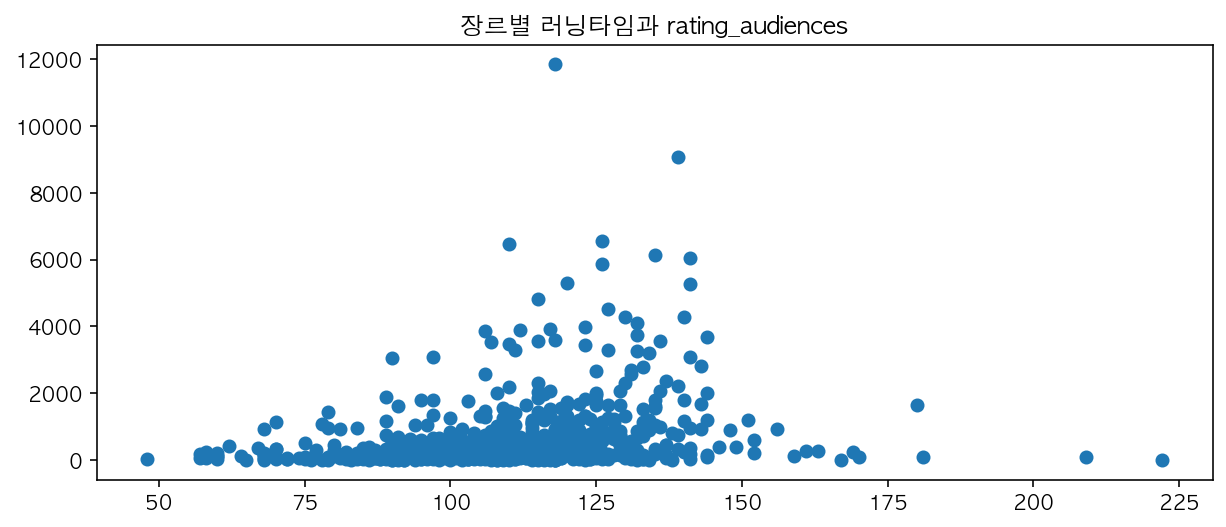

In [175]:
# 러닝타임과 rating_audiences

plt.figure(figsize=(10, 4))
plt.title("장르별 러닝타임과 rating_audiences")
plt.scatter(df4["running_times"],
            df4["rating_audiences"])

plt.show()

In [176]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times*rating_audiences', 'rating_audiences',
                 'director_power', 'actor_power', 'np.sqrt(np.log(before_news))', 'np.sqrt(np.log(after_news_0to1))']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model4 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     77.97
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          6.05e-221
Time:                        12:45:35   Log-Likelihood:                -733.27
No. Observations:                 737   AIC:                             1543.
Df Residuals:                     699   BIC:                             1717.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [177]:
# kfold 4

from sklearn.model_selection import KFold

kfold_dict['4'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df4)):
    df_train = df4.iloc[idx_train]
    df_test = df4.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['4'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['4'])/10)


학습 R2 = 0.80751765, 검증 R2 = 0.75538730
학습 R2 = 0.80840252, 검증 R2 = 0.74377570
학습 R2 = 0.80585289, 검증 R2 = 0.77808247
학습 R2 = 0.80573261, 검증 R2 = 0.78314544
학습 R2 = 0.80764826, 검증 R2 = 0.76604381
학습 R2 = 0.80481755, 검증 R2 = 0.79088956
학습 R2 = 0.80740249, 검증 R2 = 0.72770151
학습 R2 = 0.80597887, 검증 R2 = 0.76367135
학습 R2 = 0.80128613, 검증 R2 = 0.81996699
학습 R2 = 0.80913438, 검증 R2 = 0.75833659


In [178]:
# model4의 테스트 R

pred = result4.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7957602180083694

# model5
- 뉴스기사 처리 : before_news와 after_news를 하나로 묶기
    - `np.sqrt(np.log(before_news))*np.log(after_news_0to1)`

In [179]:
df5 = df4.copy()

In [180]:
# 'np.sqrt(np.log(before_news))', 'np.sqrt(np.log(after_news_0to1))'

In [181]:
# 15개의 컬럼 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times*rating_audiences', 'rating_audiences',
                 'director_power', 'actor_power', 'np.sqrt(np.log(before_news))*np.log(after_news_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model5 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df5)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     80.82
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          9.44e-223
Time:                        12:45:59   Log-Likelihood:                -731.19
No. Observations:                 737   AIC:                             1536.
Df Residuals:                     700   BIC:                             1707.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [182]:
# kfold 5

from sklearn.model_selection import KFold

kfold_dict['5'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df5)):
    df_train = df5.iloc[idx_train]
    df_test = df5.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['5'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['5'])/10)


학습 R2 = 0.80871656, 검증 R2 = 0.75615421
학습 R2 = 0.80988915, 검증 R2 = 0.74079827
학습 R2 = 0.80715583, 검증 R2 = 0.77794298
학습 R2 = 0.80747386, 검증 R2 = 0.77822997
학습 R2 = 0.80786909, 검증 R2 = 0.77635914
학습 R2 = 0.80571820, 검증 R2 = 0.79449002
학습 R2 = 0.80849025, 검증 R2 = 0.73100792
학습 R2 = 0.80561645, 검증 R2 = 0.79213873
학습 R2 = 0.80249721, 검증 R2 = 0.82097436
학습 R2 = 0.81030083, 검증 R2 = 0.75951412


In [183]:
# model5의 테스트 R

pred = result5.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7970691404424421

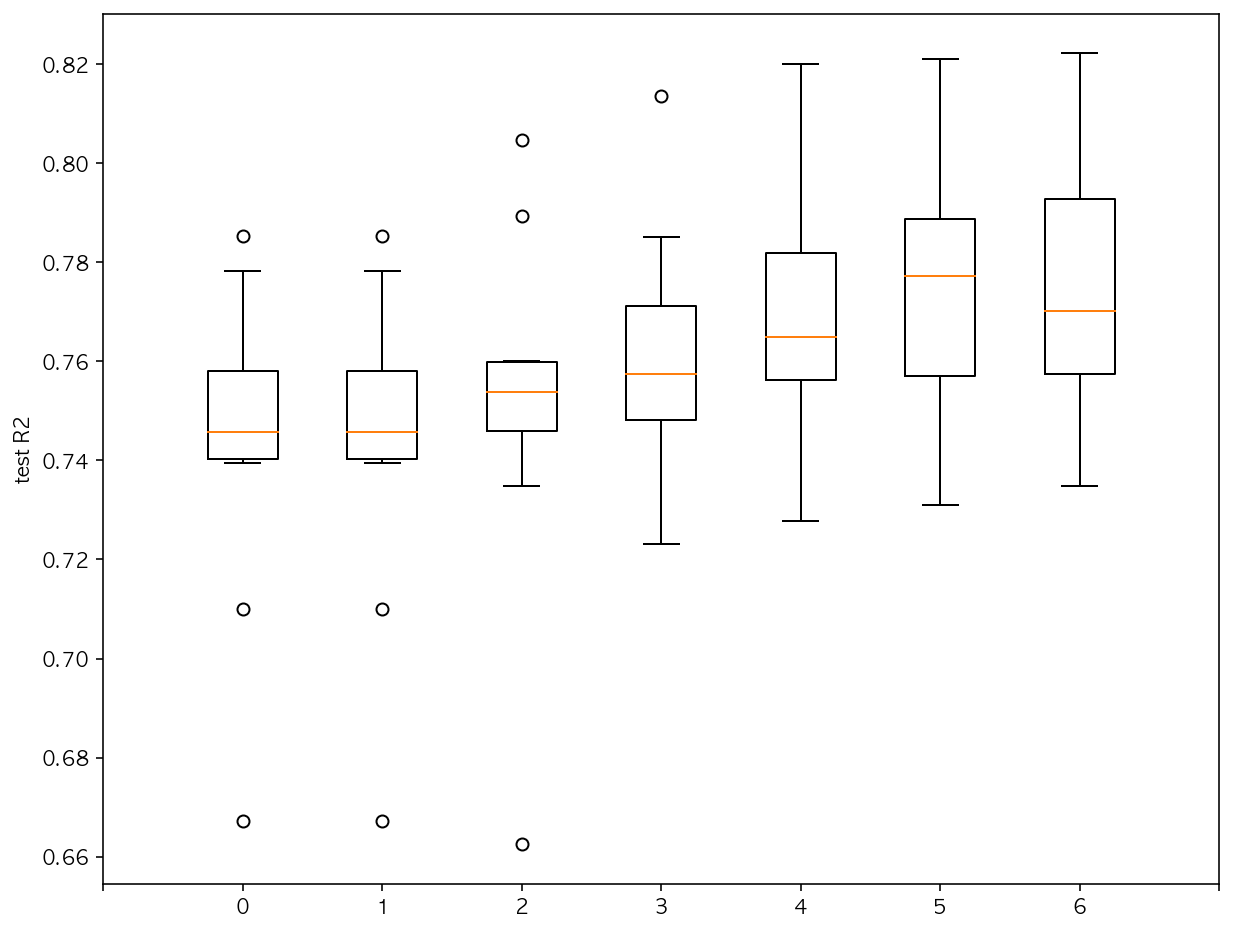

In [340]:
for i in range(0, len(kfold_dict)):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(10, 8))
plt.boxplot((kfold_df['0'], kfold_df['1'],
             kfold_df['2'], kfold_df['3'], kfold_df['4'], kfold_df['5'], kfold_df['6']))
plt.ylabel("test R2")
plt.xticks(np.arange(9), ('', '0', '1', '2', '3', '4', '5', '6'))

plt.show()

### 5. 앞으로 할 과제
- 모형 진단(잔차정규성, 이분산성)과 수정
- 다중공선성 제거 위해 VIF 수치 확인
- 개봉일을 확인해서 휴일/명절 변수 추가할 수 있는지 확인
- 카테고리 변수 구분을 정리(EX: 장르)

### 6. 참고문헌
- 뉴스 기사
    - 영화흥행 순위(매출 VS. 관객수)(https://news.mt.co.kr/mtview.php?no=2019112914134099089)
- 논문
    - 김은미,〈한국 영화의 흥행 결정 요인에 관한 연구〉, 2003
        - `스타파워 산출시 배우 수 참고(남주, 여주,남조주, 여조주)`
        - 마케팅과 홍보 영역 : 마케팅 비용 자료 얻을 수 없어 `홍보기사 개수` 포함
        - 한국 제작 영화 VS. 헐리우드 영화 흥행 요소 분석
    - 박승현, 정완규 〈한국 영화시장의 흥행결정 요인에 관한 연구: 2006-2008년 개봉작품을 중심으로〉, 2009
        - `매년 흥행 순위 100위`(기준: 한국영화연감, 영진위 자료 바탕, 전국 관객 수 기준)
        - `배급사 파워 구분` :
        - 헐리우드 배급사 자회사 설치/직배사
        - 한국메이저 배급사(CJ ENM, 쇼박스, 롯데엔터테인먼트)
        - 국내 미니 메이저 배급사(300편 중 20편 이상 배급)
        - 국내 독립 배급사(10편 이상의 배급 편수)
        - 개봉시점 : 여름방학 7-8월, 겨울방학 12-2월 시즌
   - 김유진, 권오경,〈영화 투자자를 위한 흥행성과 예측지표 발굴〉, 2017
        - `상호작용 변수 적용 : 계절 * 장르`
        - `원작여부, 실화 여부, 시리즈 여부` 구분 참고
        - 2010-2015 개봉영화 중 상업영화 + 매출액 천만 원 이상
    - 문병준, 서혜미, 김혜정, 〈한국 영화시장의 흥행에 관한 통계분석 : 2006 ~ 2010년 흥행 작품을 중심으로〉, 2011
        - 독립 변수들 : 개봉스크린 규모, 메이저 배급사, 스타배우, 관람등급, 상영시간, `비평가&관람객 평가`, 장르, 개봉 첫주 상영관수(`네이버 평점등록 관람객 수`로 대체), 수상경력, 애국심 자극 여부, 국적

In [144]:
group_a = ['씨제이이앤엠(주)', '메가박스중앙(주)플러스엠', 'CGV아트하우스', '롯데쇼핑㈜롯데엔터테인먼트',
           'CGV아트하우스,(주)대명문화공장', '롯데쇼핑㈜롯데엔터테인먼트,(주)마인스 엔터테인먼트',
           'CGV아트하우스,(주)리틀빅픽쳐스', 'CGV아트하우스,영화사 풀', '메가박스중앙(주)플러스엠,(주)키위미디어그룹',
           '롯데쇼핑㈜롯데엔터테인먼트,(주)리틀빅픽쳐스', '메가박스중앙(주)플러스엠,주식회사 키위컴퍼니',
           '씨제이 씨지브이(CJ CGV)(주)', '롯데컬처웍스(주)롯데엔터테인먼트',
           '롯데컬처웍스(주)롯데엔터테인먼트,씨네그루(주)키다리이엔티', '메가박스중앙(주)플러스엠,(주)콘텐츠 난다긴다',
           '씨제이이앤엠(주),(주)덱스터스튜디오', '(주)쇼박스', '(주)넥스트엔터테인먼트월드(NEW)', '(주)쇼박스,(주)와우픽쳐스',
           '(주)넥스트엔터테인먼트월드(NEW),(주)팬엔터테인먼트']
group_b = ['월트디즈니컴퍼니코리아(주)', '이십세기폭스코리아(주)', '유니버설픽쳐스인터내셔널 코리아(유)',
           '워너브러더스 코리아(주)', '씨네그루(주)다우기술', '(주)이수C&E', '(주)티캐스트',
           '씨네그루(주)키다리이엔티', '월트디즈니컴퍼니코리아 유한책임회사', '소니픽쳐스엔터테인먼트코리아주식회사극장배급지점',
           '(주)이수C&E,(주)스톰픽쳐스코리아', '씨네그루(주)키다리이엔티,주식회사 키위컴퍼니',
           '(주)이수C&E,(주)에이원엔터테인먼트', '씨네그루(주)키다리이엔티,(주)삼백상회',
           '(주)이수C&E,(주)시너지미디어', '(주)셀트리온엔터테인먼트', '케이티하이텔(주)']

In [145]:
df['dist_cat'] = df['distributor']

for a in group_a:
    df['dist_cat'] = df['dist_cat'].replace(a, 'A')

for b in group_b:
    df['dist_cat'] = df['dist_cat'].replace(b, 'B')

df['dist_cat'] = df['dist_cat'].apply(
    lambda data: "C" if data != 'A' and data != 'B' else data)

In [146]:
X_test['dist_cat'] = X_test['distributor']

for a in group_a:
    X_test['dist_cat'] = X_test['dist_cat'].replace(a, 'A')

for b in group_b:
    X_test['dist_cat'] = X_test['dist_cat'].replace(b, 'B')

X_test['dist_cat'] = X_test['dist_cat'].apply(
    lambda data: "C" if data != 'A' and data != 'B' else data)